# **LANL Earthquake Prediction**

Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.

In this competition, you will address when the earthquake will take place. Specifically, you’ll predict the time remaining before laboratory earthquakes occur from real-time seismic data.

This challenge is hosted by Los Alamos National Laboratory which enhances national security by ensuring the safety of the U.S. nuclear stockpile, developing technologies to reduce threats from weapons of mass destruction, and solving problems related to energy, environment, infrastructure, health, and global security concerns.

![alt text](https://www.canterbury.ac.nz/engineering/schools/cnre/research-groups-and-partnerships/eqeng/Earthquake-damage-Geotechnical-engineering-research_DPC_block.png)

This competition is much important too get to know when will earthquake happen. we will try to predict time left to the next laboratory earthquake based on seismic signal data. If we are able to predict time in which next earthquake happen, we can save millions of life.

Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

## **1. Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import time
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats

## 2. Install Kaggle library to Access Kaggle

To Access Code directly from Kaggle we will install and use some libraries.

In [0]:
# To access Kaggle Dataset

!pip install kaggle



## 3. Importing Dataset From Kaggle Using Kaggle API

In [0]:
# Colab file Access Feature
from google.colab import files

# retrived uploaded file
uploaded = files.upload()

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3057            True  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11378            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4522           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         45           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3558           False  
open-images-2019-object-detection                  2019-10-01 23:59:00  Research           $25,000      

In [0]:
# Download Earthquake Data Directly from Kaggle into Colab
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 29.3MB/s]
 97% 234M/242M [00:01<00:00, 176MB/s]
100% 242M/242M [00:01<00:00, 182MB/s]
100% 2.02G/2.03G [00:12<00:00, 202MB/s]
100% 2.03G/2.03G [00:12<00:00, 169MB/s]


In [0]:
# unzip train data for use
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


## 4. Exploratory Data **Analysis**

It helps us to visualize the data 

In [0]:
# Taking training data for further Analysis

train = pd.read_csv('train.csv', nrows = 500000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [0]:
# Printing first 10 entries of data
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


In [0]:
train.shape

(500000000, 2)

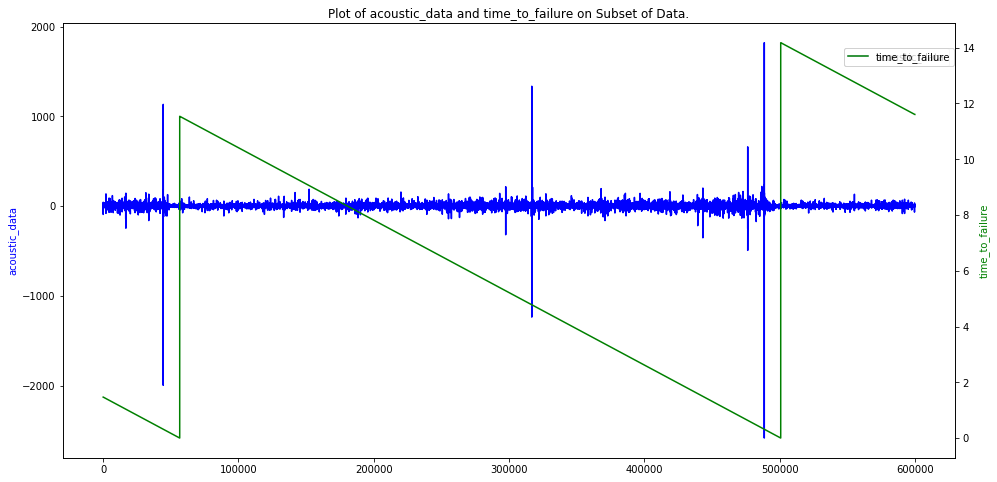

In [0]:
train_acoustic_data_subset = train['acoustic_data'].values[::100]
train_time_to_failure_subset = train['time_to_failure'].values[::100]

def plot_acoustic_time_data(train_acoustic_data_subset,train_time_to_failure_subset):
  fig, ax1 = plt.subplots(figsize=(16, 8))
  plt.title("Plot of acoustic_data and time_to_failure on Subset of Data.")
  plt.plot(train_acoustic_data_subset, color='b')
  ax1.set_ylabel('acoustic_data', color='b')
  plt.legend(['acoustic_data'], loc = (0.875, 0.9))
  ax2 = ax1.twinx()
  plt.plot(train_time_to_failure_subset, color='g')
  ax2.set_ylabel('time_to_failure', color='g')
  plt.legend(['time_to_failure'], loc=(0.875, 0.9))
  plt.grid(False)

plot_acoustic_time_data(train_acoustic_data_subset,train_time_to_failure_subset)
del train_acoustic_data_subset
del train_time_to_failure_subset

Plot on full data

![alt text](https://i.imgur.com/EPAFaPA.png)

* From the graph we can see that when there is big seismic signal activity, earthquake happens.
* every bigger seismic signal are followes by small signal values. This could be useful for predicting "time_to_failure" changes from 0 to high values

## 5. Feature Engineering

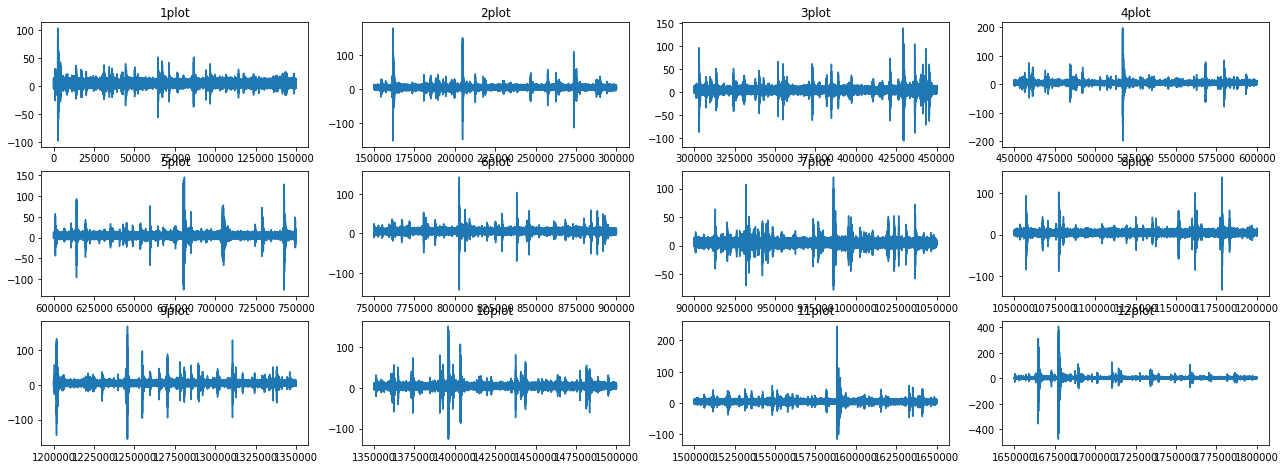

In [0]:
# Create a training file with simple derived features
rows = 150000
segments = int(np.floor(train.shape[0] / rows))
# print("Number of segments : ", segments)

# train_chunk = pd.read_csv('train.csv', iterator=True, chunksize=150000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train_st = pd.DataFrame(index=range(segments), dtype=np.float64)

y_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
plt.figure(figsize=(22, 16))


# for index,df in tqdm_notebook(enumerate(train_chunk)):
for index in tqdm_notebook(range(segments)):

    df = train.iloc[index*rows:index*rows+rows]
    X = pd.Series(df['acoustic_data'].values)
    y = df['time_to_failure'].values[-1]
    
    y_train.loc[index, 'time_to_failure'] = y
#     Taking Mean, Min, Max,Median and Std value of train data
    X_train_st.loc[index, 'mean'] = X.mean()
    X_train_st.loc[index, 'median'] = X.median()
    X_train_st.loc[index, 'std'] = X.std()
    X_train_st.loc[index, 'min'] = X.min()
    X_train_st.loc[index, 'max'] = X.max()
    X_train_st.loc[index, 'mad'] = X.mad()
    X_train_st.loc[index, 'kurtosis'] = X.kurtosis()
    X_train_st.loc[index, 'skewness'] = X.skew()
    
#     Taking mean, median, std, min ,max, mad of first 5000
    X_train_st.loc[index, 'mean_first_5000'] = X[:5000].mean()
    X_train_st.loc[index, 'median_first_5000'] = X[:5000].median()
    X_train_st.loc[index, 'std_first_5000'] = X[:5000].std()
    X_train_st.loc[index, 'min_first_5000'] = X[:5000].min()
    X_train_st.loc[index, 'max_first_5000'] = X[:5000].max()
    X_train_st.loc[index, 'mad_first_5000'] = X[:5000].mad()
    
#     Taking mean, median, std, min ,max, mad of last 5000 points
    X_train_st.loc[index, 'mean_last_5000'] = X[:-5000].mean()
    X_train_st.loc[index, 'median_last_5000'] = X[:-5000].median()
    X_train_st.loc[index, 'std_last_5000'] = X[:-5000].std()
    X_train_st.loc[index, 'min_last_5000'] = X[:-5000].min()
    X_train_st.loc[index, 'max_last_5000'] = X[:-5000].max()
    X_train_st.loc[index, 'mad_last_5000'] = X[:-5000].mad()
    
#     Taking mean, median, std, min ,max, mad of first 10000
    X_train_st.loc[index, 'mean_first_10000'] = X[:10000].mean()
    X_train_st.loc[index, 'median_first_10000'] = X[:10000].median()
    X_train_st.loc[index, 'std_first_10000'] = X[:10000].std()
    X_train_st.loc[index, 'min_first_10000'] = X[:10000].min()
    X_train_st.loc[index, 'max_first_10000'] = X[:10000].max()
    X_train_st.loc[index, 'mad_first_10000'] = X[:10000].mad()
    
#     Taking mean, median, std, min ,max,mad of last 10000 points
    X_train_st.loc[index, 'mean_last_10000'] = X[:-10000].mean()
    X_train_st.loc[index, 'median_last_10000'] = X[:-10000].median()
    X_train_st.loc[index, 'std_last_10000'] = X[:-10000].std()
    X_train_st.loc[index, 'min_last_10000'] = X[:-10000].min()
    X_train_st.loc[index, 'max_last_10000'] = X[:-10000].max()
    X_train_st.loc[index, 'mad_last_10000'] = X[:-10000].mad()
    
#     Taking mean, median, std, min ,max, mad of first 50000
    X_train_st.loc[index, 'mean_first_50000'] = X[:50000].mean()
    X_train_st.loc[index, 'median_first_50000'] = X[:50000].median()
    X_train_st.loc[index, 'std_first_50000'] = X[:50000].std()
    X_train_st.loc[index, 'min_first_50000'] = X[:50000].min()
    X_train_st.loc[index, 'max_first_50000'] = X[:50000].max()
    X_train_st.loc[index, 'mad_first_50000'] = X[:50000].mad()
    
#     Taking mean, median, std, min ,max, mad of last 10000 points
    X_train_st.loc[index, 'mean_last_50000'] = X[:-50000].mean()
    X_train_st.loc[index, 'median_last_50000'] = X[:-50000].median()
    X_train_st.loc[index, 'std_last_50000'] = X[:-50000].std()
    X_train_st.loc[index, 'min_last_50000'] = X[:-50000].min()
    X_train_st.loc[index, 'max_last_50000'] = X[:-50000].max()
    X_train_st.loc[index, 'mad_last_50000'] = X[:-50000].mad()
#     Taking mean, median, std, min ,max, mad of middle points
    X_train_st.loc[index, 'mean_middle'] = X[50000:100000].mean()
    X_train_st.loc[index, 'median_middle'] = X[50000:100000].median()
    X_train_st.loc[index, 'std_middle'] = X[50000:100000].std()
    X_train_st.loc[index, 'min_middle'] = X[50000:100000].min()
    X_train_st.loc[index, 'max_middle'] = X[50000:100000].max()
    X_train_st.loc[index, 'mad_middle'] = X[50000:100000].mad()
    
#     Appending 1, 10, 50, 95, 99 quantile value
    X_train_st.loc[index, 'q01'] = np.quantile(X,0.01)
    X_train_st.loc[index, 'q10'] = np.quantile(X,0.10)
    X_train_st.loc[index, 'q25'] = np.quantile(X,0.25)
    X_train_st.loc[index, 'q50'] = np.quantile(X,0.50)
    X_train_st.loc[index, 'q75'] = np.quantile(X,0.75)
    X_train_st.loc[index, 'q95'] = np.quantile(X,0.95)
    X_train_st.loc[index, 'q99'] = np.quantile(X,0.99)
    X_train_st.loc[index, 'q999'] = np.quantile(X,0.999)
    X_train_st.loc[index, 'q001'] = np.quantile(X,0.001)
#     Adding Absolute Quantile values
    X_train_st.loc[index, 'abs_q01'] = np.quantile(np.abs(X), 0.01)
    X_train_st.loc[index, 'abs_q10'] = np.quantile(np.abs(X), 0.10)
    X_train_st.loc[index, 'abs_q25'] = np.quantile(np.abs(X), 0.25)
    X_train_st.loc[index, 'abs_q50'] = np.quantile(np.abs(X), 0.50)
    X_train_st.loc[index, 'abs_q75'] = np.quantile(np.abs(X), 0.75)
    X_train_st.loc[index, 'abs_q95'] = np.quantile(np.abs(X), 0.95)
    X_train_st.loc[index, 'abs_q99'] = np.quantile(np.abs(X), 0.99)
    X_train_st.loc[index, 'abs_q001'] = np.quantile(np.abs(X), 0.001)
    X_train_st.loc[index, 'abs_q999'] = np.quantile(np.abs(X), 0.999)
#    Adding Inter Quantile Range
    X_train_st.loc[index, 'iqr'] = np.subtract(*np.percentile(X, [75, 25]))
#     Adding Absolute Mean, Max, MAD and Std
    X_train_st.loc[index, 'abs_max'] = np.abs(X).max()
    X_train_st.loc[index, 'abs_min'] = np.abs(X).min()
    X_train_st.loc[index, 'abs_min'] = np.abs(X).median()
    X_train_st.loc[index, 'abs_mean'] = np.abs(X).mean()
    X_train_st.loc[index, 'abs_std'] = np.abs(X).std()
    X_train_st.loc[index, 'abs_mad'] = np.abs(X).mad()
#    Adding abs sum and sum of data
    X_train_st.loc[index, 'abs_sum'] = np.abs(X).sum()
    X_train_st.loc[index, 'sum'] = X.sum()
    if index < 12:
        plt.subplot(6, 4, index + 1)
        plt.plot(df['acoustic_data'])
        plt.title(str(index + 1)+'plot')

In [0]:
# Saving the data into a file
import pickle

pickle_out = open("X_train_statistics_data.pickle","wb")
pickle.dump(X_train_st, pickle_out)
pickle_out.close()

pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

In [0]:
print(f'{X_train_st.shape[0]} samples in new train data and {X_train_st.shape[1]} columns.')

3333 samples in new train data and 76 columns.


In [0]:
X_train_st.head()

,mean,median,std,min,max,mad,kurtosis,skewness,mean_first_5000,median_first_5000,std_first_5000,min_first_5000,max_first_5000,mad_first_5000,mean_last_5000,median_last_5000,std_last_5000,min_last_5000,max_last_5000,mad_last_5000,mean_first_10000,median_first_10000,std_first_10000,min_first_10000,max_first_10000,mad_first_10000,mean_last_10000,median_last_10000,std_last_10000,min_last_10000,max_last_10000,mad_last_10000,mean_first_50000,median_first_50000,std_first_50000,min_first_50000,max_first_50000,mad_first_50000,mean_last_50000,median_last_50000,std_last_50000,min_last_50000,max_last_50000,mad_last_50000,mean_middle,median_middle,std_middle,min_middle,max_middle,mad_middle,q01,q10,q25,q50,q75,q95,q99,q999,q001,abs_q01,abs_q10,abs_q25,abs_q50,abs_q75,abs_q95,abs_q99,abs_q001,abs_q999,iqr,abs_max,abs_min,abs_mean,abs_std,abs_mad,abs_sum,sum
0,4.884113333333334,5.0,5.101106130606765,-98.0,104.0,3.263401356801146,33.662481293451094,-0.024061166628209,5.1582,5.0,15.301986894537066,-98.0,104.0,8.992756159999994,4.883944827586207,5.0,5.148104121428263,-98.0,104.0,3.285555265445269,5.1820,5.0,11.207151110947080,-98.0,104.0,6.080918000000027,4.899007142857143,5.0,5.149568345326903,-98.0,104.0,3.266198108978748,4.96210,5.0,6.488551888989741,-98.0,104.0,3.840790527999776,5.01594,5.0,5.680238425232313,-98.0,104.0,3.496516822400835,5.06978,5.0,4.735373187699627,-56.0,52.0,3.159328220000080,-8.0,0.0,3.0,5.0,7.0,11.0,18.0,40.00000000000000,-30.0,0.0,1.0,3.0,5.0,7.0,12.0,20.0,0.0,46.0,4.0,104.0,5.0,5.576566666666666,4.333324673993449,2.886248923554534,836485.0,732617.0
1,4.725766666666667,5.0,6.588823781946801,-154.0,181.0,3.574301851111739,98.758517178736923,0.390560504371834,4.9332,5.0,4.257506668533418,-23.0,29.0,2.832631359999989,4.717303448275862,5.0,6.676676627174299,-154.0,181.0,3.613490714482117,4.7772,5.0,3.976750132226240,-23.0,29.0,2.828804319999977,4.712292857142857,5.0,6.749068715608835,-154.0,181.0,3.633754076633296,4.69840,5.0,7.305232697765033,-154.0,181.0,3.938227872000155,4.69448,5.0,7.073147660255528,-154.0,181.0,3.717267911999816,4.69056,5.0,6.833255501883058,-150.0,152.0,3.496293683200085,-11.0,0.0,2.0,5.0,7.0,12.0,21.0,59.00000000000000,-47.0,0.0,1.0,3.0,5.0,7.0,12.0,24.0,0.0,75.0,5.0,181.0,5.0,5.734166666666667,5.732776965581381,3.128925288890267,860125.0,708865.0
2,4.906393333333333,5.0,6.967397033524431,-106.0,140.0,3.948411362132931,33.555211406928983,0.217390561445685,4.8606,5.0,10.633502805584962,-87.0,97.0,5.238656160000001,4.898103448275862,5.0,6.944914145235699,-106.0,140.0,3.934180030915585,4.6814,5.0,8.454717160510244,-87.0,97.0,4.525331479999985,4.886771428571429,5.0,6.750457481513978,-106.0,140.0,3.827796322040845,4.70610,5.0,6.104836457315087,-87.0,97.0,3.746134667999810,4.81588,5.0,5.981737008376110,-87.0,97.0,3.666929687999522,4.92566,5.0,5.854053208092600,-61.0,67.0,3.583052471200008,-15.0,0.0,2.0,5.0,7.0,13.0,26.0,59.00000000000000,-47.0,0.0,1.0,3.0,5.0,8.0,14.0,30.0,0.0,65.0,5.0,140.0,5.0,6.152646666666667,5.895944714483795,3.457726543201072,922897.0,735959.0
3,4.902240000000000,5.0,6.922305187180113,-199.0,197.0,3.647117068799020,116.548171687628383,0.757277536411098,5.0448,5.0,4.286218297457410,-19.0,27.0,3.187918719999976,4.897337931034483,5.0,7.016014684107342,-199.0,197.0,3.688087309583798,5.0364,5.0,6.866177209987221,-48.0,75.0,4.317090560000019,4.882935714285714,5.0,7.069301040635708,-199.0,197.0,3.695670445817180,4.84364,5.0,6.238109475682244,-63.0,75.0,3.835939086399706,4.83663,5.0,7.475954731142466,-199.0,197.0,3.775320947600408,4.82962,5.0,8.536205714001968,-199.0,197.0,3.714678133599821,-12.0,0.0,2.0,5.0,7.0,12.0,22.0,60.00099999998929,-50.0,0.0,1.0,3.0,5.0,8.0,13.0,26.0,0.0,74.0,5.0,199.0,5.0,5.933960000000000,6.061213600190591,3.223349855466274,890094.0,735336.0
4,4.908720000000000,5.0,7.301110189758817,-126.0,145.0,3.826051623466296,52.977904834406473,0.064531069271374,4.9396,5.0,6.385021968725575,-44.0,57.0,3.781242719999967,4.912537931034483,5.0,7.367907620496208,-126.0,145.0,3.83

# Fourier Feature Transformation

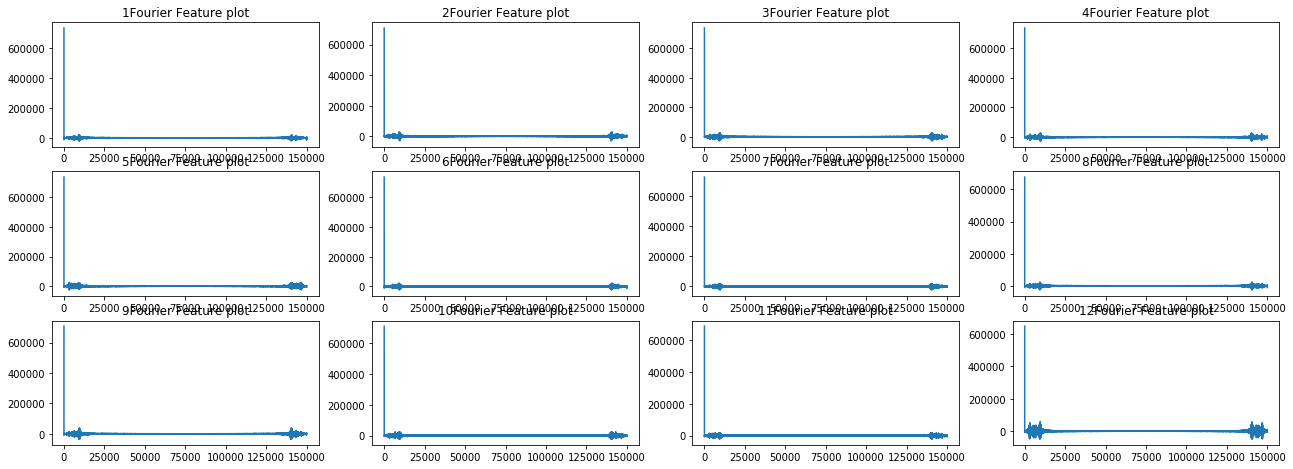

In [0]:
X_train_fft = pd.DataFrame(index=range(segments), dtype=np.float64) 
plt.figure(figsize=(22, 16))

for index in tqdm_notebook(range(segments)):

    df = train.iloc[index*rows:index*rows+rows]
    
#    Adding Fourier Features of acoustic Data
    X_FFT = np.real(np.fft.fft(df['acoustic_data'].values))
  
#     Taking mean, median, std, min ,max, mad
    X_train_fft.loc[index, 'fft_mean'] = X_FFT.mean()
    X_train_fft.loc[index, 'fft_std'] = X_FFT.std()
    X_train_fft.loc[index, 'fft_max'] = X_FFT.max()
    X_train_fft.loc[index, 'fft_min'] = X_FFT.min()
#     X_train_fft.loc[index, 'fft_median'] = X_FFT.median() no attribute median error occur
#     X_train_fft.loc[index, 'fft_mad'] = X_FFT.mad() no attribute mad error occur
    
    
#     Taking mean, median, std, min ,max, mad of first 5000
    X_train_fft.loc[index, 'fft_mean_first_5000'] = X_FFT[:5000].mean()
    X_train_fft.loc[index, 'fft_std_first_5000'] = X_FFT[:5000].std()
    X_train_fft.loc[index, 'fft_min_first_5000'] = X_FFT[:5000].min()
    X_train_fft.loc[index, 'fft_max_first_5000'] = X_FFT[:5000].max()
    
#     Taking mean, median, std, min ,max, mad of last 5000 points
    X_train_fft.loc[index, 'fft_mean_last_5000'] = X_FFT[:-5000].mean()
    X_train_fft.loc[index, 'fft_std_last_5000'] = X_FFT[:-5000].std()
    X_train_fft.loc[index, 'fft_min_last_5000'] = X_FFT[:-5000].min()
    X_train_fft.loc[index, 'fft_max_last_5000'] = X_FFT[:-5000].max()
    
#     Taking mean, median, std, min ,max, mad of first 10000
    X_train_fft.loc[index, 'fft_mean_first_10000'] = X_FFT[:10000].mean()
    X_train_fft.loc[index, 'fft_std_first_10000'] = X_FFT[:10000].std()
    X_train_fft.loc[index, 'fft_min_first_10000'] = X_FFT[:10000].min()
    X_train_fft.loc[index, 'fft_max_first_10000'] = X_FFT[:10000].max()
    
#     Taking mean, median, std, min ,max,mad of last 10000 points
    X_train_fft.loc[index, 'fft_mean_last_10000'] = X_FFT[:-10000].mean()
    X_train_fft.loc[index, 'fft_std_last_10000'] = X_FFT[:-10000].std()
    X_train_fft.loc[index, 'fft_min_last_10000'] = X_FFT[:-10000].min()
    X_train_fft.loc[index, 'fft_max_last_10000'] = X_FFT[:-10000].max()
    
#     Taking mean, median, std, min ,max, mad of first 50000
    X_train_fft.loc[index, 'fft_mean_first_50000'] = X_FFT[:50000].mean()
    X_train_fft.loc[index, 'fft_std_first_50000'] = X_FFT[:50000].std()
    X_train_fft.loc[index, 'fft_min_first_50000'] = X_FFT[:50000].min()
    X_train_fft.loc[index, 'fft_max_first_50000'] = X_FFT[:50000].max()
    
#     Taking mean, median, std, min ,max, mad of last 10000 points
    X_train_fft.loc[index, 'fft_mean_last_50000'] = X_FFT[:-50000].mean()
    X_train_fft.loc[index, 'fft_std_last_50000'] = X_FFT[:-50000].std()
    X_train_fft.loc[index, 'fft_min_last_50000'] = X_FFT[:-50000].min()
    X_train_fft.loc[index, 'fft_max_last_50000'] = X_FFT[:-50000].max()
#       Taking mean, median, std, min ,max, mad of middle points
    X_train_fft.loc[index, 'fft_mean_middle'] = X_FFT[50000:100000].mean()
    X_train_fft.loc[index, 'fft_std_middle'] = X_FFT[50000:100000].std()
    X_train_fft.loc[index, 'fft_min_middle'] = X_FFT[50000:100000].min()
    X_train_fft.loc[index, 'fft_max_middle'] = X_FFT[50000:100000].max()
    
#     Appending 1, 10, 50, 95, 99 quantile value
    X_train_fft.loc[index, 'fft_q01'] = np.quantile(X_FFT, 0.01)
    X_train_fft.loc[index, 'fft_q10'] = np.quantile(X_FFT, 0.10)
    X_train_fft.loc[index, 'fft_q05'] = np.quantile(X_FFT,0.05)
    X_train_fft.loc[index, 'fft_q25'] = np.quantile(X_FFT,0.25)
    X_train_fft.loc[index, 'fft_q75'] = np.quantile(X_FFT,0.75)
    X_train_fft.loc[index, 'fft_q95'] = np.quantile(X_FFT,0.95)
    X_train_fft.loc[index, 'fft_q99'] = np.quantile(X_FFT,0.99)
    X_train_fft.loc[index, 'fft_q001'] = np.quantile(X_FFT, 0.001)
    X_train_fft.loc[index, 'fft_q999'] = np.quantile(X_FFT, 0.999)
    X_train_fft.loc[index, 'abs_fft_q01'] = np.quantile(np.abs(X_FFT), 0.01)
    X_train_fft.loc[index, 'abs_fft_q10'] = np.quantile(np.abs(X_FFT), 0.10)
    X_train_fft.loc[index, 'abs_fft_q05'] = np.quantile(np.abs(X_FFT),0.05)
    X_train_fft.loc[index, 'abs_fft_q25'] = np.quantile(np.abs(X_FFT),0.25)
    X_train_fft.loc[index, 'abs_fft_q75'] = np.quantile(np.abs(X_FFT),0.75)
    X_train_fft.loc[index, 'abs_fft_q95'] = np.quantile(np.abs(X_FFT),0.95)
    X_train_fft.loc[index, 'abs_fft_q99'] = np.quantile(np.abs(X_FFT),0.99)
    X_train_fft.loc[index, 'abs_fft_q001'] = np.quantile(np.abs(X_FFT), 0.001)
    X_train_fft.loc[index, 'abs_fft_q999'] = np.quantile(np.abs(X_FFT), 0.999)
#    Adding Inter Quantile Range
    X_train_fft.loc[index, 'fft_iqr'] = np.subtract(*np.percentile(X_FFT, [75, 25]))
#     Adding Absolute Mean, Max, MAD and Std
    X_train_fft.loc[index, 'fft_abs_max'] = np.abs(X_FFT).max()
    X_train_fft.loc[index, 'fft_abs_min'] = np.abs(X_FFT).min()
    X_train_fft.loc[index, 'fft_abs_mean'] = np.abs(X_FFT).mean()
    X_train_fft.loc[index, 'fft_abs_std'] = np.abs(X_FFT).std()
    if index < 12:
        plt.subplot(6, 4, index + 1)
        plt.plot(X_FFT)
        plt.title(str(index + 1)+'Fourier Feature plot')


In [0]:
pickle_out = open("X_train_fourier_feature_data.pickle","wb")
pickle.dump(X_train_fft, pickle_out)
pickle_out.close()

In [0]:
print(f'{X_train_fft.shape[0]} Fourier Feature samples in new train data and {X_train_fft.shape[1]} columns.')

3333 Fourier Feature samples in new train data and 55 columns.


In [0]:
X_train_fft.head()

,fft_mean,fft_std,fft_max,fft_min,fft_mean_first_5000,fft_std_first_5000,fft_min_first_5000,fft_max_first_5000,fft_mean_last_5000,fft_std_last_5000,fft_min_last_5000,fft_max_last_5000,fft_mean_first_10000,fft_std_first_10000,fft_min_first_10000,fft_max_first_10000,fft_mean_last_10000,fft_std_last_10000,fft_min_last_10000,fft_max_last_10000,fft_mean_first_50000,fft_std_first_50000,fft_min_first_50000,fft_max_first_50000,fft_mean_last_50000,fft_std_last_50000,fft_min_last_50000,fft_max_last_50000,fft_mean_middle,fft_std_middle,fft_min_middle,fft_max_middle,fft_q01,fft_q10,fft_q05,fft_q25,fft_q75,fft_q95,fft_q99,fft_q001,fft_q999,abs_fft_q01,abs_fft_q10,abs_fft_q05,abs_fft_q25,abs_fft_q75,abs_fft_q95,abs_fft_q99,abs_fft_q001,abs_fft_q999,fft_iqr,fft_abs_max,fft_abs_min,fft_abs_mean,fft_abs_std
0,12.000000000000004,2349.811481800189085,732617.0,-20121.154171234855312,143.414190186984257,10469.699920073184330,-12837.254225910462992,732617.0,12.503661469421145,2373.396305055629455,-20121.154171234855312,732617.0,79.058871634820960,7988.153137966965005,-20121.154171234855312,732617.0,12.422244881372485,2278.459481096861964,-20121.154171234855312,732617.0,22.161164068499417,3678.628707248468800,-20121.154171234855312,732617.0,14.247067965750292,2623.606362892815923,-20121.154171234855312,732617.0,6.332971863001166,483.927952485232993,-2194.731306048602619,2163.872441347189124,-4404.537029830144093,-1052.555098646009128,-1622.831835542537874,-479.454912249460222,495.000014898740460,1620.809806981756992,4435.602455032304533,-9936.625185403059731,10129.306954731808219,8.707646141490221,86.987434923781052,43.066465672639303,222.957755220359871,911.942911894949930,2541.005287983428389,6061.493878781766398,0.725448572511605,11953.392375088566041,974.454927148200682,732617.0,0.030760333588660,799.024456503296051,2209.823051266687798
1,4.999999999999998,2566.032248433366476,708865.0,-31056.675076437579264,142.654418896587686,10343.179859690597368,-11771.116138276469428,708865.0,5.179291525486967,2566.535121664750022,-31056.675076437579264,708865.0,85.773436891525861,8309.288865859598445,-31056.675076437575626,708865.0,4.373584781176399,2389.751486360050876,-31056.675076437575626,708865.0,14.549564378325483,3845.273259819868144,-31056.675076437575626,708865.0,7.314442810837254,2740.162957172293773,-31056.675076437575626,708865.0,0.079321243349027,480.369573416659705,-2243.318354211750375,2143.351158282302549,-5965.749781674444421,-1120.852462735536847,-1866.865973059095040,-505.679985865177287,497.538636969563015,1880.188004085308876,5963.507327490360694,-13154.541515832848745,13569.889444139327679,9.279794243071221,89.337585021258974,44.059513365357255,228.274514661600818,954.263331674272649,3350.268727844701061,8237.617650808489998,0.821792676642035,15948.968414113674953,1003.218622834740245,708865.0,0.023529777367742,930.063503094676548,2391.553549517814645
2,5.000000000000000,2683.549049300198476,735959.0,-27654.557067499525147,192.230494823846726,10784.873881607962176,-15992.574637120495026,735959.0,3.617980960378058,2678.265652040112855,-27654.557067499525147,735959.0,96.017037524486852,8680.101771817424378,-27654.557067499525147,735959.0,3.826791425740892,2490.294832144365046,-27654.557067499525147,735959.0,11.699959849489352,4012.635216568710803,-27654.557067499525147,735959.0,9.008465075255325,2857.932264437093636,-27654.557067499525147,735959.0,6.316970301021299,484.043166138525294,-2224.281292108278649,2062.631412757731596,-6514.075443014900884,-1137.777893689885786,-1939.964987974328778,-501.238310366235453,500.494469450963607,1963.027088241337879,6442.726128133837847,-14187.069636603184335,13653.200067262308949,8.710236955213690,89.581656783703750,44.454267582709399,229.301040484755902,962.652770839390314,3644.728000305861315,8749.046751227080676,0.802337237482272,16169.826420367768151,1001.732779817199116,735959.0,0.007695239047905,965.332563195223770,2503.915642036476129
3,5.000000000000003,2685.788524809800037,735336.0,-25622.3

# Rolling Window Feature

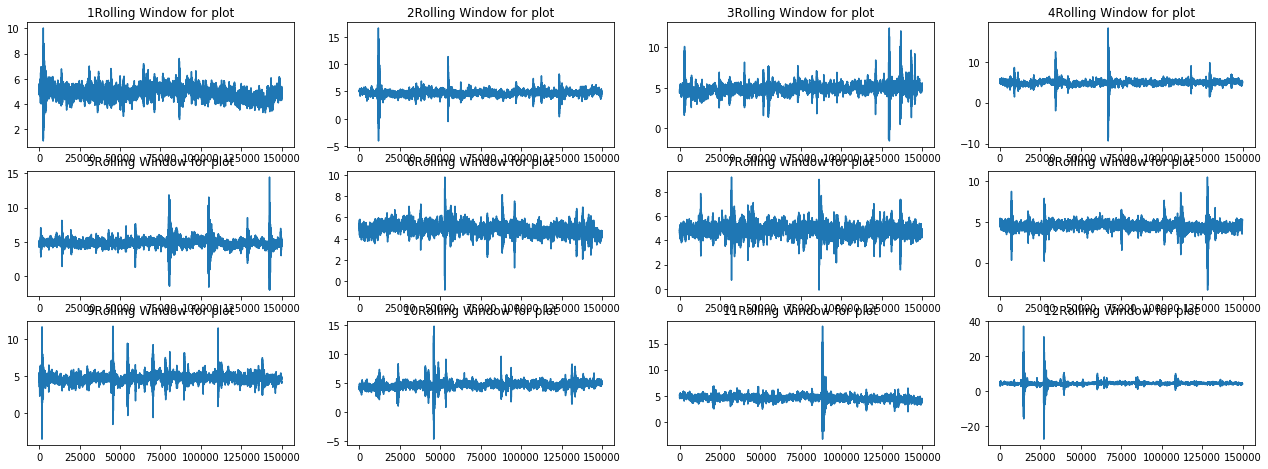

In [0]:
X_train_roll = pd.DataFrame(index=range(segments), dtype=np.float64) 
plt.figure(figsize=(22, 16))
for index in tqdm_notebook(range(segments)):
    df = train.iloc[index*rows:index*rows+rows]
    
    
    X_rolling = df['acoustic_data'].rolling(100).mean().dropna().values
    #     Taking mean, median, std, min ,max, no median and mad in rolling
    X_train_roll.loc[index, 'roll_mean'] = X_rolling.mean()
    X_train_roll.loc[index, 'roll_std'] = X_rolling.std()
    X_train_roll.loc[index, 'roll_max'] = X_rolling.max()
    X_train_roll.loc[index, 'roll_min'] = X_rolling.min()
    #     Appending 1, 10, 50, 95, 99 quantile value
    X_train_roll.loc[index, 'roll_q01'] = np.quantile(X_rolling, 0.01)
    X_train_roll.loc[index, 'roll_q10'] = np.quantile(X_rolling, 0.10)
    X_train_roll.loc[index, 'roll_q05'] = np.quantile(X_rolling,0.05)
    X_train_roll.loc[index, 'roll_q25'] = np.quantile(X_rolling,0.25)
    X_train_roll.loc[index, 'roll_q75'] = np.quantile(X_rolling,0.75)
    X_train_roll.loc[index, 'roll_q95'] = np.quantile(X_rolling,0.95)
    X_train_roll.loc[index, 'roll_q99'] = np.quantile(X_rolling,0.99)
    X_train_roll.loc[index, 'roll_q001'] = np.quantile(X_rolling, 0.001)
    X_train_roll.loc[index, 'roll_q999'] = np.quantile(X_rolling, 0.999)
    X_train_roll.loc[index, 'abs_roll_q01'] = np.quantile(np.abs(X_rolling), 0.01)
    X_train_roll.loc[index, 'abs_roll_q10'] = np.quantile(np.abs(X_rolling), 0.10)
    X_train_roll.loc[index, 'abs_roll_q05'] = np.quantile(np.abs(X_rolling),0.05)
    X_train_roll.loc[index, 'abs_roll_q25'] = np.quantile(np.abs(X_rolling),0.25)
    X_train_roll.loc[index, 'abs_roll_q75'] = np.quantile(np.abs(X_rolling),0.75)
    X_train_roll.loc[index, 'abs_roll_q95'] = np.quantile(np.abs(X_rolling),0.95)
    X_train_roll.loc[index, 'abs_roll_q99'] = np.quantile(np.abs(X_rolling),0.99)
    X_train_roll.loc[index, 'abs_roll_q001'] = np.quantile(np.abs(X_rolling), 0.001)
    X_train_roll.loc[index, 'abs_roll_q999'] = np.quantile(np.abs(X_rolling), 0.999)
    
    X_Srolling = df['acoustic_data'].rolling(100).std().dropna().values
    #     Taking mean, median, std, min ,max, no median and mad in rolling
    X_train_roll.loc[index, 'Sroll_mean'] = X_Srolling.mean()
    X_train_roll.loc[index, 'Sroll_std'] = X_Srolling.std()
    X_train_roll.loc[index, 'Sroll_max'] = X_Srolling.max()
    X_train_roll.loc[index, 'Sroll_min'] = X_Srolling.min()
    #     Appending 1, 10, 50, 95, 99 quantile value
    X_train_roll.loc[index, 'Sroll_q01'] = np.quantile(X_Srolling, 0.01)
    X_train_roll.loc[index, 'Sroll_q10'] = np.quantile(X_Srolling, 0.10)
    X_train_roll.loc[index, 'Sroll_q05'] = np.quantile(X_Srolling,0.05)
    X_train_roll.loc[index, 'Sroll_q25'] = np.quantile(X_Srolling,0.25)
    X_train_roll.loc[index, 'Sroll_q75'] = np.quantile(X_Srolling,0.75)
    X_train_roll.loc[index, 'Sroll_q95'] = np.quantile(X_Srolling,0.95)
    X_train_roll.loc[index, 'Sroll_q99'] = np.quantile(X_Srolling,0.99)
    X_train_roll.loc[index, 'Sroll_q001'] = np.quantile(X_Srolling, 0.001)
    X_train_roll.loc[index, 'Sroll_q999'] = np.quantile(X_Srolling, 0.999)
    X_train_roll.loc[index, 'Sabs_roll_q01'] = np.quantile(np.abs(X_Srolling), 0.01)
    X_train_roll.loc[index, 'Sabs_roll_q10'] = np.quantile(np.abs(X_Srolling), 0.10)
    X_train_roll.loc[index, 'Sabs_roll_q05'] = np.quantile(np.abs(X_Srolling),0.05)
    X_train_roll.loc[index, 'Sabs_roll_q25'] = np.quantile(np.abs(X_Srolling),0.25)
    X_train_roll.loc[index, 'Sabs_roll_q75'] = np.quantile(np.abs(X_Srolling),0.75)
    X_train_roll.loc[index, 'Sabs_roll_q95'] = np.quantile(np.abs(X_Srolling),0.95)
    X_train_roll.loc[index, 'Sabs_roll_q99'] = np.quantile(np.abs(X_Srolling),0.99)
    X_train_roll.loc[index, 'Sabs_roll_q001'] = np.quantile(np.abs(X_Srolling), 0.001)
    X_train_roll.loc[index, 'Sabs_roll_q999'] = np.quantile(np.abs(X_Srolling), 0.999)
    if index < 12:
      plt.subplot(6, 4, index + 1)
      plt.plot(X_rolling)
      plt.title(str(index + 1)+'Rolling Window for plot')    

In [0]:
pickle_out = open("X_train_roll.pickle","wb")
pickle.dump(X_train_roll, pickle_out)
pickle_out.close()

In [0]:
print(X_train_roll.shape)

(3333, 44)


In [0]:
X_train_roll.head()

,roll_mean,roll_std,roll_max,roll_min,roll_q01,roll_q10,roll_q05,roll_q25,roll_q75,roll_q95,roll_q99,roll_q001,roll_q999,abs_roll_q01,abs_roll_q10,abs_roll_q05,abs_roll_q25,abs_roll_q75,abs_roll_q95,abs_roll_q99,abs_roll_q001,abs_roll_q999,Sroll_mean,Sroll_std,Sroll_max,Sroll_min,Sroll_q01,Sroll_q10,Sroll_q05,Sroll_q25,Sroll_q75,Sroll_q95,Sroll_q99,Sroll_q001,Sroll_q999,Sabs_roll_q01,Sabs_roll_q10,Sabs_roll_q05,Sabs_roll_q25,Sabs_roll_q75,Sabs_roll_q95,Sabs_roll_q99,Sabs_roll_q001,Sabs_roll_q999
0,4.883863549942963,0.452293846429352,10.039999999999999,1.040000000000000,3.81,4.31,4.16,4.59,5.17,5.58,5.95,3.330,6.941000000000058,3.81,4.31,4.16,4.59,5.17,5.58,5.95,3.330,6.941000000000058,4.050449943320652,3.111524285420867,52.335254741797996,1.935422069177468,2.302633538390867,2.576114057328325,2.475638882952861,2.786312142157923,4.018894767410026,8.195903140156636,16.948796924021416,2.129006024815257,44.586414644527459,2.302633538390867,2.576114057328325,2.475638882952861,2.786312142157923,4.018894767410026,8.195903140156636,16.948796924021416,2.129006024815257,44.586414644527459
1,4.725623311385514,0.496219791758936,16.670000000000002,-4.090000000000000,3.64,4.21,4.05,4.46,4.99,5.39,5.75,1.578,8.681000000000058,3.64,4.21,4.05,4.46,4.99,5.39,5.75,1.659,8.681000000000058,4.436358953659417,4.893430954489131,87.972617410995625,1.991370270831667,2.300285445615412,2.576819745344408,2.475965274474054,2.783265286774281,4.115246350493425,9.829922366802840,23.457270415662862,2.143569190880847,70.165455977209476,2.300285445615412,2.576819745344408,2.475965274474054,2.783265286774281,4.115246350493425,9.829922366802840,23.457270415662862,2.143569190880847,70.165455977209476
2,4.906088151513332,0.530151428835058,12.380000000000001,-1.550000000000000,3.65,4.33,4.14,4.62,5.19,5.66,6.26,1.930,8.511000000000058,3.65,4.33,4.14,4.62,5.19,5.66,6.26,1.930,8.511000000000058,4.917333917974993,4.959233301601424,53.353832234820928,1.969463855669570,2.374613206142917,2.645274040146761,2.538591035287758,2.873406453404103,4.476650984877465,13.485266932561050,28.598375315864878,2.183674491411595,48.039593616356591,2.374613206142917,2.645274040146761,2.538591035287758,2.873406453404103,4.476650984877465,13.485266932561050,28.598375315864878,2.183674491411595,48.039593616356591
3,4.901946217837106,0.581874300302291,18.260000000000002,-9.369999999999999,3.76,4.34,4.16,4.62,5.19,5.61,6.09,0.238,9.444000000000234,3.76,4.34,4.16,4.62,5.19,5.61,6.09,1.389,9.444000000000234,4.533343221511053,5.247129605841999,103.996664185040842,1.955334583474206,2.330539452875163,2.595470024188614,2.496441912446866,2.800054112031086,4.173642645134606,10.367489979973232,26.380301420383734,2.138020392178035,79.941286902824203,2.330539452875163,2.595470024188614,2.496441912446866,2.800054112031086,4.173642645134606,10.367489979973232,26.380301420383734,2.138020392178035,79.941286902824203
4,4.909174788693870,0.566266591213842,14.410000000000000,-1.970000000000000,3.59,4.38,4.21,4.63,5.16,5.63,6.48,0.899,9.521000000000058,3.59,4.38,4.21,4.63,5.16,5.63,6.48,1.059,9.521000000000058,4.761149253538696,5.556923976801867,74.460127625868367,1.981123036272089,2.314731042254673,2.596403884473822,2.491520974761425,2.802668281289634,4.151475337123756,12.413820092659988,34.718195968585825,2.145490925902775,56.672954910998961,2.314731042254673,2.596403884473822,2.491520974761425,2.802668281289634,4.151475337123756,12.413820092659988,34.718195968585825,2.145490925902775,56.672954910998961


# Unzipping test data

In [0]:
!unzip test.zip
!ls

Archive:  test.zip
  inflating: seg_430e66.csv          
  inflating: seg_d1a281.csv          
  inflating: seg_05a1b0.csv          
  inflating: seg_f8dd7e.csv          
  inflating: seg_b9bdd7.csv          
  inflating: seg_24c1c9.csv          
  inflating: seg_c5abaa.csv          
  inflating: seg_6262c4.csv          
  inflating: seg_734a88.csv          
  inflating: seg_94a133.csv          
  inflating: seg_d0c280.csv          
  inflating: seg_d36737.csv          
  inflating: seg_f80e44.csv          
  inflating: seg_07c815.csv          
  inflating: seg_7c9433.csv          
  inflating: seg_211486.csv          
  inflating: seg_78ded2.csv          
  inflating: seg_f11f77.csv          
  inflating: seg_b3883e.csv          
  inflating: seg_3db0a8.csv          
  inflating: seg_81f798.csv          
  inflating: seg_0a45a1.csv          
  inflating: seg_dc188b.csv          
  inflating: seg_4a9e8d.csv          
  inflating: seg_32fc4e.csv          
  inflating: seg_7b2994.csv    

In [0]:
# Taking package id from sample submission file

submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test_st = pd.DataFrame(columns=X_train_st.columns, dtype=np.float64, index=submission.index)

# Test Features
## Statistics feature from Test Data

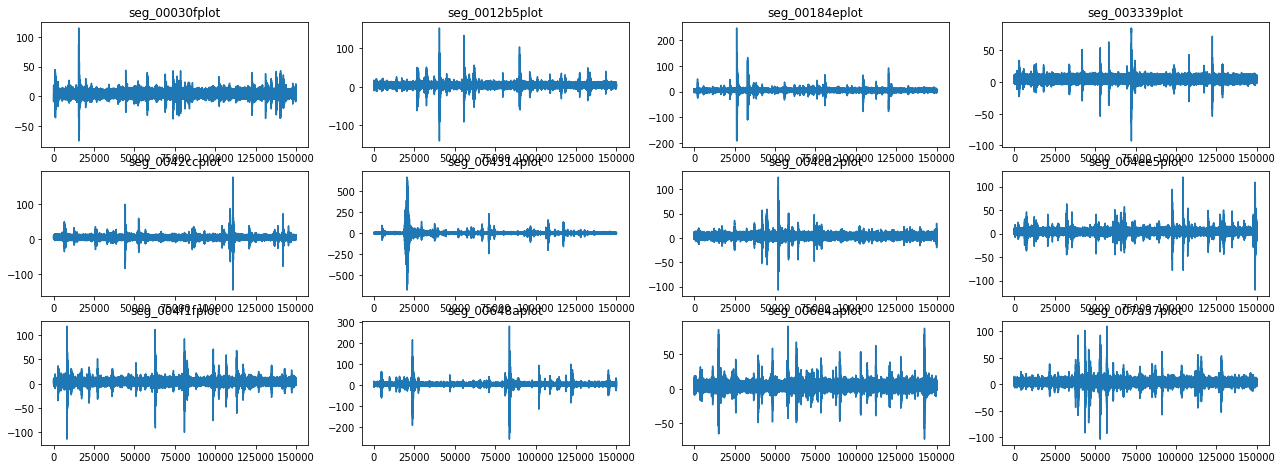

In [0]:
plt.figure(figsize=(22, 16))
for i, seg_id in enumerate(tqdm_notebook(X_test_st.index)):
    seg = pd.read_csv(seg_id + '.csv')
    index = seg_id
    X = pd.Series(seg['acoustic_data'].values)
    #     Taking Mean, Min, Max and Std value of train data
    X_test_st.loc[index, 'mean'] = X.mean()
    X_test_st.loc[index, 'median'] = X.median()
    X_test_st.loc[index, 'std'] = X.std()
    X_test_st.loc[index, 'min'] = X.min()
    X_test_st.loc[index, 'max'] = X.max()
    X_test_st.loc[index, 'mad'] = X.mad()
    X_test_st.loc[index, 'kurtosis'] = X.kurtosis()
    X_test_st.loc[index, 'skewness'] = X.skew()
    
#     Taking mean, median, std, min ,max, mad of first 5000
    X_test_st.loc[index, 'mean_first_5000'] = X[:5000].mean()
    X_test_st.loc[index, 'median_first_5000'] = X[:5000].median()
    X_test_st.loc[index, 'std_first_5000'] = X[:5000].std()
    X_test_st.loc[index, 'min_first_5000'] = X[:5000].min()
    X_test_st.loc[index, 'max_first_5000'] = X[:5000].max()
    X_test_st.loc[index, 'mad_first_5000'] = X[:5000].mad()
    
#     Taking mean, median, std, min ,max, mad of last 5000 points
    X_test_st.loc[index, 'mean_last_5000'] = X[:-5000].mean()
    X_test_st.loc[index, 'median_last_5000'] = X[:-5000].median()
    X_test_st.loc[index, 'std_last_5000'] = X[:-5000].std()
    X_test_st.loc[index, 'min_last_5000'] = X[:-5000].min()
    X_test_st.loc[index, 'max_last_5000'] = X[:-5000].max()
    X_test_st.loc[index, 'mad_last_5000'] = X[:-5000].mad()
    
#     Taking mean, median, std, min ,max, mad of first 10000
    X_test_st.loc[index, 'mean_first_10000'] = X[:10000].mean()
    X_test_st.loc[index, 'median_first_10000'] = X[:10000].median()
    X_test_st.loc[index, 'std_first_10000'] = X[:10000].std()
    X_test_st.loc[index, 'min_first_10000'] = X[:10000].min()
    X_test_st.loc[index, 'max_first_10000'] = X[:10000].max()
    X_test_st.loc[index, 'mad_first_10000'] = X[:10000].mad()
    
#     Taking mean, median, std, min ,max,mad of last 10000 points
    X_test_st.loc[index, 'mean_last_10000'] = X[:-10000].mean()
    X_test_st.loc[index, 'median_last_10000'] = X[:-10000].median()
    X_test_st.loc[index, 'std_last_10000'] = X[:-10000].std()
    X_test_st.loc[index, 'min_last_10000'] = X[:-10000].min()
    X_test_st.loc[index, 'max_last_10000'] = X[:-10000].max()
    X_test_st.loc[index, 'mad_last_10000'] = X[:-10000].mad()
    
#     Taking mean, median, std, min ,max, mad of first 50000
    X_test_st.loc[index, 'mean_first_50000'] = X[:50000].mean()
    X_test_st.loc[index, 'median_first_50000'] = X[:50000].median()
    X_test_st.loc[index, 'std_first_50000'] = X[:50000].std()
    X_test_st.loc[index, 'min_first_50000'] = X[:50000].min()
    X_test_st.loc[index, 'max_first_50000'] = X[:50000].max()
    X_test_st.loc[index, 'mad_first_50000'] = X[:50000].mad()
    
#     Taking mean, median, std, min ,max, mad of last 10000 points
    X_test_st.loc[index, 'mean_last_50000'] = X[:-50000].mean()
    X_test_st.loc[index, 'median_last_50000'] = X[:-50000].median()
    X_test_st.loc[index, 'std_last_50000'] = X[:-50000].std()
    X_test_st.loc[index, 'min_last_50000'] = X[:-50000].min()
    X_test_st.loc[index, 'max_last_50000'] = X[:-50000].max()
    X_test_st.loc[index, 'mad_last_50000'] = X[:-50000].mad()
#     Taking mean, median, std, min ,max, mad of middle points
    X_test_st.loc[index, 'mean_middle'] = X[50000:100000].mean()
    X_test_st.loc[index, 'median_middle'] = X[50000:100000].median()
    X_test_st.loc[index, 'std_middle'] = X[50000:100000].std()
    X_test_st.loc[index, 'min_middle'] = X[50000:100000].min()
    X_test_st.loc[index, 'max_middle'] = X[50000:100000].max()
    X_test_st.loc[index, 'mad_middle'] = X[50000:100000].mad()
    
#     Appending 1, 10, 50, 95, 99 quantile value
    X_test_st.loc[index, 'q01'] = np.quantile(X,0.01)
    X_test_st.loc[index, 'q10'] = np.quantile(X,0.10)
    X_test_st.loc[index, 'q25'] = np.quantile(X,0.25)
    X_test_st.loc[index, 'q50'] = np.quantile(X,0.50)
    X_test_st.loc[index, 'q75'] = np.quantile(X,0.75)
    X_test_st.loc[index, 'q95'] = np.quantile(X,0.95)
    X_test_st.loc[index, 'q99'] = np.quantile(X,0.99)
    X_test_st.loc[index, 'q999'] = np.quantile(X,0.999)
    X_test_st.loc[index, 'q001'] = np.quantile(X,0.001)
#     Adding Absolute Quantile values
    X_test_st.loc[index, 'abs_q01'] = np.quantile(np.abs(X), 0.01)
    X_test_st.loc[index, 'abs_q10'] = np.quantile(np.abs(X), 0.10)
    X_test_st.loc[index, 'abs_q25'] = np.quantile(np.abs(X), 0.25)
    X_test_st.loc[index, 'abs_q50'] = np.quantile(np.abs(X), 0.50)
    X_test_st.loc[index, 'abs_q75'] = np.quantile(np.abs(X), 0.75)
    X_test_st.loc[index, 'abs_q95'] = np.quantile(np.abs(X), 0.95)
    X_test_st.loc[index, 'abs_q99'] = np.quantile(np.abs(X), 0.99)
    X_test_st.loc[index, 'abs_q001'] = np.quantile(np.abs(X), 0.001)
    X_test_st.loc[index, 'abs_q999'] = np.quantile(np.abs(X), 0.999)
#    Adding Inter Quantile Range
    X_test_st.loc[index, 'iqr'] = np.subtract(*np.percentile(X, [75, 25]))
#     Adding Absolute Mean, Max, MAD and Std
    X_test_st.loc[index, 'abs_max'] = np.abs(X).max()
    X_test_st.loc[index, 'abs_min'] = np.abs(X).min()
    X_test_st.loc[index, 'abs_min'] = np.abs(X).median()
    X_test_st.loc[index, 'abs_mean'] = np.abs(X).mean()
    X_test_st.loc[index, 'abs_std'] = np.abs(X).std()
    X_test_st.loc[index, 'abs_mad'] = np.abs(X).mad()
#    Adding abs sum and sum of data
    X_test_st.loc[index, 'abs_sum'] = np.abs(X).sum()
    X_test_st.loc[index, 'sum'] = X.sum()
    if i < 12:
        plt.subplot(6, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(index +'plot')

In [0]:
pickle_out = open("X_test_statistics_data.pickle","wb")
pickle.dump(X_test_st, pickle_out)
pickle_out.close()

In [0]:
print(f'{X_test_st.shape[0]} samples in new test data and {X_test_st.shape[1]} columns.')

2624 samples in new test data and 76 columns.


In [0]:
X_test_st.head()

,mean,median,std,min,max,mad,kurtosis,skewness,mean_first_5000,median_first_5000,std_first_5000,min_first_5000,max_first_5000,mad_first_5000,mean_last_5000,median_last_5000,std_last_5000,min_last_5000,max_last_5000,mad_last_5000,mean_first_10000,median_first_10000,std_first_10000,min_first_10000,max_first_10000,mad_first_10000,mean_last_10000,median_last_10000,std_last_10000,min_last_10000,max_last_10000,mad_last_10000,mean_first_50000,median_first_50000,std_first_50000,min_first_50000,max_first_50000,mad_first_50000,mean_last_50000,median_last_50000,std_last_50000,min_last_50000,max_last_50000,mad_last_50000,mean_middle,median_middle,std_middle,min_middle,max_middle,mad_middle,q01,q10,q25,q50,q75,q95,q99,q999,q001,abs_q01,abs_q10,abs_q25,abs_q50,abs_q75,abs_q95,abs_q99,abs_q001,abs_q999,iqr,abs_max,abs_min,abs_mean,abs_std,abs_mad,abs_sum,sum
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780000000000,4.0,4.893689687028069,-75.0,115.0,3.248521054133214,28.837568099164539,0.327907635264522,4.3660,4.0,6.534139805406584,-36.0,45.0,4.225497599999986,4.496758620689655,4.0,4.935912618536890,-75.0,115.0,3.268363885850099,4.3842,4.0,5.226846310370640,-36.0,45.0,3.461908040000013,4.507800000000000,4.0,4.802856701880597,-75.0,115.0,3.194108668571512,4.46644,4.0,5.350451034532767,-75.0,115.0,3.254984128000121,4.48968,4.0,4.942863321657314,-75.0,115.0,3.221896428799996,4.51292,4.0,4.498430592012903,-38.0,43.0,3.188574470400031,-8.0,0.0,2.0,4.0,7.0,11.0,18.0,34.0,-26.0,0.0,1.0,3.0,5.0,7.0,11.0,19.0,0.0,38.00000000000000,5.0,115.0,5.0,5.224606666666666,4.102160897639040,2.807930307554293,783691.0,673767.0
seg_0012b5,4.171153333333334,4.0,5.922839443206628,-140.0,152.0,3.429208497866453,56.218954550493322,0.295707859154105,4.1316,4.0,3.555954218220549,-12.0,21.0,2.750443840000024,4.179282758620690,4.0,5.997445050702884,-140.0,152.0,3.464904896075907,4.0635,4.0,3.523252628028278,-12.0,22.0,2.722154800000019,4.174200000000000,4.0,6.054530928949229,-140.0,152.0,3.481658382857460,4.01786,4.0,6.249515353149148,-140.0,152.0,3.554167480000113,4.13451,4.0,6.634390492824087,-140.0,152.0,3.674865248800265,4.25116,4.0,6.996248823786724,-91.0,133.0,3.788769321600098,-12.0,-1.0,2.0,4.0,7.0,11.0,20.0,48.0,-42.0,0.0,1.0,2.0,4.0,7.0,12.0,24.0,0.0,57.00000000000000,5.0,152.0,4.0,5.198340000000000,5.045368597304222,2.973616196267252,779751.0,625673.0
seg_00184e,4.610260000000000,5.0,6.946990077490285,-193.0,248.0,3.461984010667016,162.118283628401656,0.428688288294736,4.2788,4.0,4.369449505120426,-26.0,49.0,2.876623840000003,4.609220689655173,5.0,7.044128830250165,-193.0,248.0,3.500389619786290,4.2452,4.0,3.950118644260117,-26.0,49.0,2.787877440000015,4.601907142857143,5.0,7.144000043759689,-193.0,248.0,3.536708911122716,4.55518,5.0,9.793473000415229,-193.0,248.0,4.122374956800089,4.63849,5.0,7.663805050952640,-193.0,248.0,3.623821126800034,4.72180,5.0,4.641443269059859,-55.0,66.0,3.121861584000027,-11.0,0.0,2.0,5.0,7.0,11.0,20.0,65.0,-57.0,0.0,1.0,3.0,5.0,7.0,12.0,25.0,0.0,80.00099999998929,5.0,248.0,5.0,5.597193333333333,6.179524903483504,3.092979526398344,839579.0,691539.0
seg_003339,4.531473333333333,5.0,4.114146602958288,-93.0,85.0,2.678502757955490,41.241827462130018,0.061889362911379,4.3236,4.0,4.667508989603985,-23.0,34.0,3.111697279999995,4.532165517241380,5.0,4.153361107075523,-93.0,85.0,2.694733600570678,4.3834,4.0,4.001275479212366,-23.0,34.0,2.797595279999997,4.536092857142857,5.0,4.193616926110177,-93.0,85.0,2.711078910612341,4.49052,5.0,3.664087695508022,-30.0,51.0,2.643144929599854,4.55260,5.0,4.396588056648306,-93.0,85.0,2.787227808000122,4.61468,5.0,5.022659956620567,-93.0,85.0,2.929646942400027,-5.0,1.0,3.0,5.0,7.0,10.0,14.0,35.0,-24.0,0.0,1.0,3.0,5.0,7.0,10.0,16.0,0.0,40.00000000000000,4.0,93.0,5.0,4.961486666666667,3.583863234509939,2.403213949244566,744223.0,679721.0
seg_0042cc,4.128340000000000,4.0,5.797163636220498,-147.0,177.0,3.283855587732982,79.539707613111105,0.073898350757301,4

## Test Fourier Feature

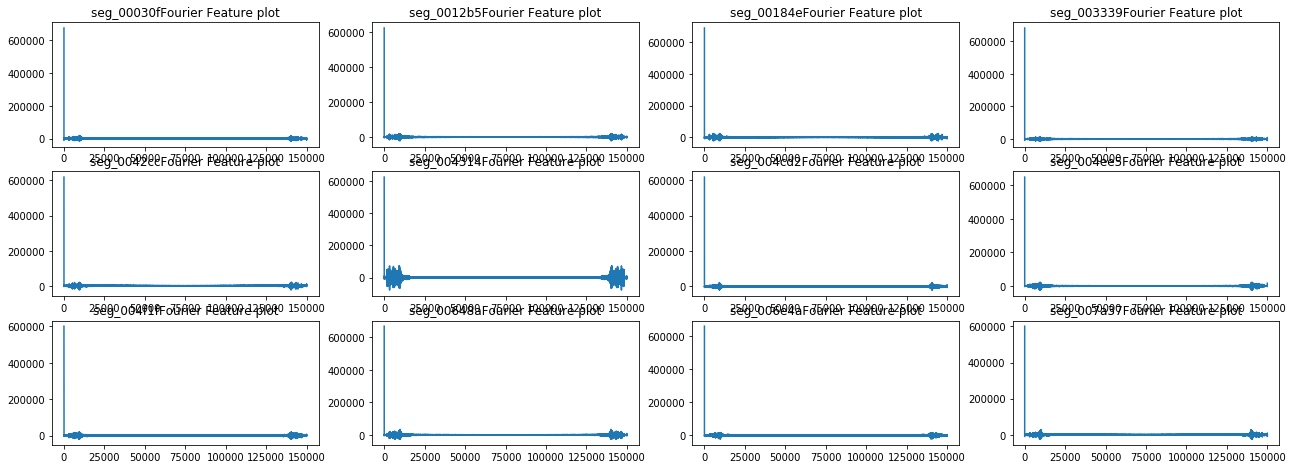

In [0]:
plt.figure(figsize=(22, 16))
X_test_fft = pd.DataFrame(columns=X_train_fft.columns, dtype=np.float64, index=submission.index)
for i, seg_id in enumerate(tqdm_notebook(X_test_fft.index)):
    seg = pd.read_csv(seg_id + '.csv')
    index = seg_id
#     X = pd.Series(seg['acoustic_data'].values)
    X_FFT = np.real(np.fft.fft(seg['acoustic_data'].values))
  
#     Taking mean, median, std, min ,max, mad
    X_test_fft.loc[index, 'fft_mean'] = X_FFT.mean()
    X_test_fft.loc[index, 'fft_std'] = X_FFT.std()
    X_test_fft.loc[index, 'fft_max'] = X_FFT.max()
    X_test_fft.loc[index, 'fft_min'] = X_FFT.min()
#     X_train_fft.loc[index, 'fft_median'] = X_FFT.median() no attribute median error occur
#     X_train_fft.loc[index, 'fft_mad'] = X_FFT.mad() no attribute mad error occur
    
    
#     Taking mean, median, std, min ,max, mad of first 5000
    X_test_fft.loc[index, 'fft_mean_first_5000'] = X_FFT[:5000].mean()
    X_test_fft.loc[index, 'fft_std_first_5000'] = X_FFT[:5000].std()
    X_test_fft.loc[index, 'fft_min_first_5000'] = X_FFT[:5000].min()
    X_test_fft.loc[index, 'fft_max_first_5000'] = X_FFT[:5000].max()
    
#     Taking mean, median, std, min ,max, mad of last 5000 points
    X_test_fft.loc[index, 'fft_mean_last_5000'] = X_FFT[:-5000].mean()
    X_test_fft.loc[index, 'fft_std_last_5000'] = X_FFT[:-5000].std()
    X_test_fft.loc[index, 'fft_min_last_5000'] = X_FFT[:-5000].min()
    X_test_fft.loc[index, 'fft_max_last_5000'] = X_FFT[:-5000].max()
    
#     Taking mean, median, std, min ,max, mad of first 10000
    X_test_fft.loc[index, 'fft_mean_first_10000'] = X_FFT[:10000].mean()
    X_test_fft.loc[index, 'fft_std_first_10000'] = X_FFT[:10000].std()
    X_test_fft.loc[index, 'fft_min_first_10000'] = X_FFT[:10000].min()
    X_test_fft.loc[index, 'fft_max_first_10000'] = X_FFT[:10000].max()
    
#     Taking mean, median, std, min ,max,mad of last 10000 points
    X_test_fft.loc[index, 'fft_mean_last_10000'] = X_FFT[:-10000].mean()
    X_test_fft.loc[index, 'fft_std_last_10000'] = X_FFT[:-10000].std()
    X_test_fft.loc[index, 'fft_min_last_10000'] = X_FFT[:-10000].min()
    X_test_fft.loc[index, 'fft_max_last_10000'] = X_FFT[:-10000].max()
    
#     Taking mean, median, std, min ,max, mad of first 50000
    X_test_fft.loc[index, 'fft_mean_first_50000'] = X_FFT[:50000].mean()
    X_test_fft.loc[index, 'fft_std_first_50000'] = X_FFT[:50000].std()
    X_test_fft.loc[index, 'fft_min_first_50000'] = X_FFT[:50000].min()
    X_test_fft.loc[index, 'fft_max_first_50000'] = X_FFT[:50000].max()
    
#     Taking mean, median, std, min ,max, mad of last 10000 points
    X_test_fft.loc[index, 'fft_mean_last_50000'] = X_FFT[:-50000].mean()
    X_test_fft.loc[index, 'fft_std_last_50000'] = X_FFT[:-50000].std()
    X_test_fft.loc[index, 'fft_min_last_50000'] = X_FFT[:-50000].min()
    X_test_fft.loc[index, 'fft_max_last_50000'] = X_FFT[:-50000].max()
#       Taking mean, median, std, min ,max, mad of middle points
    X_test_fft.loc[index, 'fft_mean_middle'] = X_FFT[50000:100000].mean()
    X_test_fft.loc[index, 'fft_std_middle'] = X_FFT[50000:100000].std()
    X_test_fft.loc[index, 'fft_min_middle'] = X_FFT[50000:100000].min()
    X_test_fft.loc[index, 'fft_max_middle'] = X_FFT[50000:100000].max()
    
#     Appending 1, 10, 50, 95, 99 quantile value
    X_test_fft.loc[index, 'fft_q01'] = np.quantile(X_FFT, 0.01)
    X_test_fft.loc[index, 'fft_q10'] = np.quantile(X_FFT, 0.10)
    X_test_fft.loc[index, 'fft_q05'] = np.quantile(X_FFT,0.05)
    X_test_fft.loc[index, 'fft_q25'] = np.quantile(X_FFT,0.25)
    X_test_fft.loc[index, 'fft_q75'] = np.quantile(X_FFT,0.75)
    X_test_fft.loc[index, 'fft_q95'] = np.quantile(X_FFT,0.95)
    X_test_fft.loc[index, 'fft_q99'] = np.quantile(X_FFT,0.99)
    X_test_fft.loc[index, 'fft_q001'] = np.quantile(X_FFT, 0.001)
    X_test_fft.loc[index, 'fft_q999'] = np.quantile(X_FFT, 0.999)
    X_test_fft.loc[index, 'abs_fft_q01'] = np.quantile(np.abs(X_FFT), 0.01)
    X_test_fft.loc[index, 'abs_fft_q10'] = np.quantile(np.abs(X_FFT), 0.10)
    X_test_fft.loc[index, 'abs_fft_q05'] = np.quantile(np.abs(X_FFT),0.05)
    X_test_fft.loc[index, 'abs_fft_q25'] = np.quantile(np.abs(X_FFT),0.25)
    X_test_fft.loc[index, 'abs_fft_q75'] = np.quantile(np.abs(X_FFT),0.75)
    X_test_fft.loc[index, 'abs_fft_q95'] = np.quantile(np.abs(X_FFT),0.95)
    X_test_fft.loc[index, 'abs_fft_q99'] = np.quantile(np.abs(X_FFT),0.99)
    X_test_fft.loc[index, 'abs_fft_q001'] = np.quantile(np.abs(X_FFT), 0.001)
    X_test_fft.loc[index, 'abs_fft_q999'] = np.quantile(np.abs(X_FFT), 0.999)
#    Adding Inter Quantile Range
    X_test_fft.loc[index, 'fft_iqr'] = np.subtract(*np.percentile(X_FFT, [75, 25]))
#     Adding Absolute Mean, Max, MAD and Std
    X_test_fft.loc[index, 'fft_abs_max'] = np.abs(X_FFT).max()
    X_test_fft.loc[index, 'fft_abs_min'] = np.abs(X_FFT).min()
    X_test_fft.loc[index, 'fft_abs_mean'] = np.abs(X_FFT).mean()
    X_test_fft.loc[index, 'fft_abs_std'] = np.abs(X_FFT).std()
    if i < 12:
        plt.subplot(6, 4, i + 1)
        plt.plot(X_FFT)
        plt.title(index+'Fourier Feature plot')


In [0]:
pickle_out = open("X_test_fourier_feature_data.pickle","wb")
pickle.dump(X_test_fft, pickle_out)
pickle_out.close()

In [0]:
print(f'{X_test_fft.shape[0]} Fourier Feature samples in new test data and {X_test_fft.shape[1]} columns.')

2624 Fourier Feature samples in new test data and 55 columns.


In [0]:
X_test_fft.head()

,fft_mean,fft_std,fft_max,fft_min,fft_mean_first_5000,fft_std_first_5000,fft_min_first_5000,fft_max_first_5000,fft_mean_last_5000,fft_std_last_5000,fft_min_last_5000,fft_max_last_5000,fft_mean_first_10000,fft_std_first_10000,fft_min_first_10000,fft_max_first_10000,fft_mean_last_10000,fft_std_last_10000,fft_min_last_10000,fft_max_last_10000,fft_mean_first_50000,fft_std_first_50000,fft_min_first_50000,fft_max_first_50000,fft_mean_last_50000,fft_std_last_50000,fft_min_last_50000,fft_max_last_50000,fft_mean_middle,fft_std_middle,fft_min_middle,fft_max_middle,fft_q01,fft_q10,fft_q05,fft_q25,fft_q75,fft_q95,fft_q99,fft_q001,fft_q999,abs_fft_q01,abs_fft_q10,abs_fft_q05,abs_fft_q25,abs_fft_q75,abs_fft_q95,abs_fft_q99,abs_fft_q001,abs_fft_q999,fft_iqr,fft_abs_max,fft_abs_min,fft_abs_mean,fft_abs_std
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.000000000000000,2198.344035859719042,673767.0,-14758.442558580365585,101.844081931609097,9701.079075706336880,-10703.597967036639602,673767.0,5.254080736494559,2210.092818873864417,-14758.442558580365585,673767.0,46.619609032390102,7348.450631839355083,-14758.442558580365585,673767.0,5.756600829318827,2136.160596576472017,-14758.442558580365585,673767.0,12.771151655393469,3416.674191363672890,-14758.442558580365585,673767.0,6.349454172303266,2439.623869419035600,-14758.442558580365585,673767.0,-0.072243310786934,479.358156445136274,-2213.702630322809910,2099.185348297934979,-4382.449488747987743,-1079.707369923140959,-1678.489341093438270,-485.801934781507725,486.201390134192252,1661.823673296736615,4470.876940913101862,-8529.072776298235112,9008.299126742254884,8.637174008255501,87.410829055296844,43.399848727387379,222.748384484787437,927.189861952453157,2656.927258122034345,5692.239069011948231,0.822184362902518,10283.036668238240964,972.003324915699977,673767.0,0.012821946350812,800.764616234096934,2047.317398301362346
seg_0012b5,5.000000000000000,2289.922378597143961,625673.0,-22626.387705690489383,120.863831785034947,9214.856063111184994,-16203.387012489618428,625673.0,5.321906075117552,2279.423725508183452,-22626.387705690489383,625673.0,50.434688315243761,7314.249322120479519,-22626.387705690489383,625673.0,6.217439043955309,2143.125330256424149,-22626.387705690489383,625673.0,13.691932612109792,3414.868111161386423,-22626.387705690489383,625673.0,6.911658693945104,2439.163296160960726,-22626.387705690489383,625673.0,0.131384775780418,487.461803449112836,-2077.969566642462723,2820.008144074953634,-5535.380427095753475,-1112.658515427772727,-1811.536524518819533,-499.019587052970053,497.452948491507641,1834.636639706151072,5462.314638127812032,-11415.221700072455860,11071.938922903707862,8.969362275353266,88.797531136009013,44.674379865342395,228.886344062835065,947.937429670893721,3161.897474281945506,7277.397546625185896,0.983560236740982,12987.879010537631984,996.472535544477751,625673.0,0.000326969101593,888.484051736535434,2110.536801339846079
seg_00184e,7.999999999999996,2611.055629434194998,691539.0,-23593.939293521976651,142.677092088852532,10145.109703978732796,-15704.462822064764623,691539.0,8.153911745925020,2607.856166205617683,-23593.939293521976651,691539.0,78.004918187572585,8354.250782856750448,-23593.939293521973013,691539.0,7.920947125711402,2394.735716474897345,-23593.939293521973013,691539.0,16.829142521723160,3858.864574636480029,-23593.939293521973013,691539.0,10.496378739138413,2750.109720933360222,-23593.939293521973013,691539.0,4.163614956553666,485.067975819572325,-2210.886503347941471,2024.782334366491341,-6645.792357836574411,-1130.475877586757633,-1938.837969396134213,-490.811968022370138,506.433390705874558,1927.431862032147592,6617.537833834437151,-14033.625477808431242,13708.175700127936580,8.469478002471318,87.717278463084199,43.898088277988883,225.687333433586787,960.014876614185141,3631.172195088225180,8860.646099144589243,0.830975704499416,16012.176104221565765,997.245358728244696,691539.0,0.001163626154010,965.3180095071927

## Test Rolling Feature

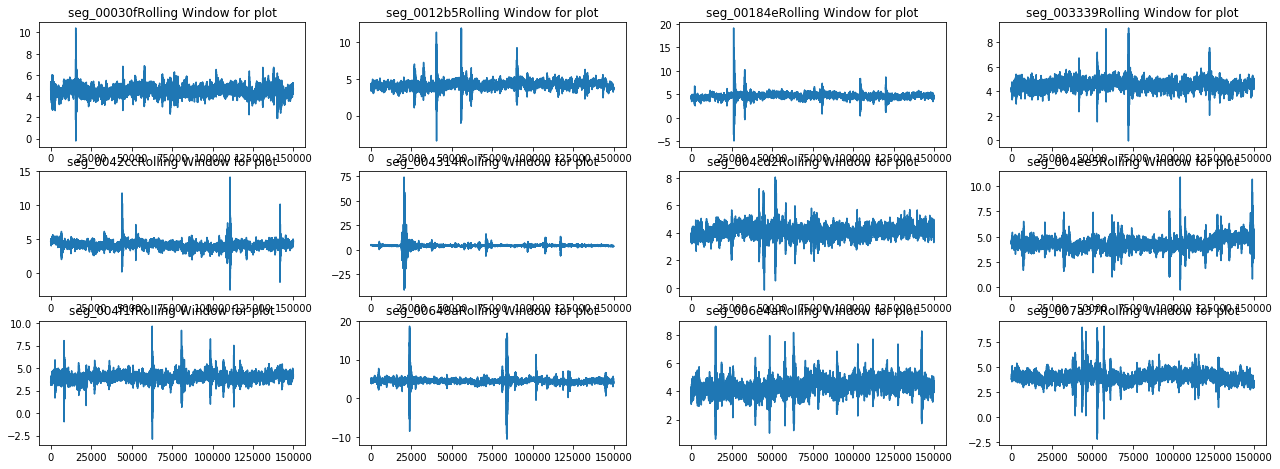

In [0]:
plt.figure(figsize=(22, 16))
X_test_roll = pd.DataFrame(columns=X_train_roll.columns, dtype=np.float64, index=submission.index)
for i, seg_id in enumerate(tqdm_notebook(X_test_roll.index)):
    seg = pd.read_csv(seg_id + '.csv')
    index = seg_id
    X_rolling = seg['acoustic_data'].rolling(100).mean().dropna().values
    #     Taking mean, median, std, min ,max, no median and mad in rolling
    X_test_roll.loc[index, 'roll_mean'] = X_rolling.mean()
    X_test_roll.loc[index, 'roll_std'] = X_rolling.std()
    X_test_roll.loc[index, 'roll_max'] = X_rolling.max()
    X_test_roll.loc[index, 'roll_min'] = X_rolling.min()
    #     Appending 1, 10, 50, 95, 99 quantile value
    X_test_roll.loc[index, 'roll_q01'] = np.quantile(X_rolling, 0.01)
    X_test_roll.loc[index, 'roll_q10'] = np.quantile(X_rolling, 0.10)
    X_test_roll.loc[index, 'roll_q05'] = np.quantile(X_rolling,0.05)
    X_test_roll.loc[index, 'roll_q25'] = np.quantile(X_rolling,0.25)
    X_test_roll.loc[index, 'roll_q75'] = np.quantile(X_rolling,0.75)
    X_test_roll.loc[index, 'roll_q95'] = np.quantile(X_rolling,0.95)
    X_test_roll.loc[index, 'roll_q99'] = np.quantile(X_rolling,0.99)
    X_test_roll.loc[index, 'roll_q001'] = np.quantile(X_rolling, 0.001)
    X_test_roll.loc[index, 'roll_q999'] = np.quantile(X_rolling, 0.999)
    X_test_roll.loc[index, 'abs_roll_q01'] = np.quantile(np.abs(X_rolling), 0.01)
    X_test_roll.loc[index, 'abs_roll_q10'] = np.quantile(np.abs(X_rolling), 0.10)
    X_test_roll.loc[index, 'abs_roll_q05'] = np.quantile(np.abs(X_rolling),0.05)
    X_test_roll.loc[index, 'abs_roll_q25'] = np.quantile(np.abs(X_rolling),0.25)
    X_test_roll.loc[index, 'abs_roll_q75'] = np.quantile(np.abs(X_rolling),0.75)
    X_test_roll.loc[index, 'abs_roll_q95'] = np.quantile(np.abs(X_rolling),0.95)
    X_test_roll.loc[index, 'abs_roll_q99'] = np.quantile(np.abs(X_rolling),0.99)
    X_test_roll.loc[index, 'abs_roll_q001'] = np.quantile(np.abs(X_rolling), 0.001)
    X_test_roll.loc[index, 'abs_roll_q999'] = np.quantile(np.abs(X_rolling), 0.999)
    
    X_Srolling = seg['acoustic_data'].rolling(100).std().dropna().values
    #     Taking mean, median, std, min ,max, no median and mad in rolling
    X_test_roll.loc[index, 'Sroll_mean'] = X_Srolling.mean()
    X_test_roll.loc[index, 'Sroll_std'] = X_Srolling.std()
    X_test_roll.loc[index, 'Sroll_max'] = X_Srolling.max()
    X_test_roll.loc[index, 'Sroll_min'] = X_Srolling.min()
    #     Appending 1, 10, 50, 95, 99 quantile value
    X_test_roll.loc[index, 'Sroll_q01'] = np.quantile(X_Srolling, 0.01)
    X_test_roll.loc[index, 'Sroll_q10'] = np.quantile(X_Srolling, 0.10)
    X_test_roll.loc[index, 'Sroll_q05'] = np.quantile(X_Srolling,0.05)
    X_test_roll.loc[index, 'Sroll_q25'] = np.quantile(X_Srolling,0.25)
    X_test_roll.loc[index, 'Sroll_q75'] = np.quantile(X_Srolling,0.75)
    X_test_roll.loc[index, 'Sroll_q95'] = np.quantile(X_Srolling,0.95)
    X_test_roll.loc[index, 'Sroll_q99'] = np.quantile(X_Srolling,0.99)
    X_test_roll.loc[index, 'Sroll_q001'] = np.quantile(X_Srolling, 0.001)
    X_test_roll.loc[index, 'Sroll_q999'] = np.quantile(X_Srolling, 0.999)
    X_test_roll.loc[index, 'Sabs_roll_q01'] = np.quantile(np.abs(X_Srolling), 0.01)
    X_test_roll.loc[index, 'Sabs_roll_q10'] = np.quantile(np.abs(X_Srolling), 0.10)
    X_test_roll.loc[index, 'Sabs_roll_q05'] = np.quantile(np.abs(X_Srolling),0.05)
    X_test_roll.loc[index, 'Sabs_roll_q25'] = np.quantile(np.abs(X_Srolling),0.25)
    X_test_roll.loc[index, 'Sabs_roll_q75'] = np.quantile(np.abs(X_Srolling),0.75)
    X_test_roll.loc[index, 'Sabs_roll_q95'] = np.quantile(np.abs(X_Srolling),0.95)
    X_test_roll.loc[index, 'Sabs_roll_q99'] = np.quantile(np.abs(X_Srolling),0.99)
    X_test_roll.loc[index, 'Sabs_roll_q001'] = np.quantile(np.abs(X_Srolling), 0.001)
    X_test_roll.loc[index, 'Sabs_roll_q999'] = np.quantile(np.abs(X_Srolling), 0.999)
    if i < 12:
      plt.subplot(6, 4, i + 1)
      plt.plot(X_rolling)
      plt.title(index +'Rolling Window for plot')    

In [0]:
pickle_out = open("X_test_roll.pickle","wb")
pickle.dump(X_train_roll, pickle_out)
pickle_out.close()

In [0]:
X_test_roll.shape

(2624, 44)

In [0]:
X_test_roll.head()

,roll_mean,roll_std,roll_max,roll_min,roll_q01,roll_q10,roll_q05,roll_q25,roll_q75,roll_q95,roll_q99,roll_q001,roll_q999,abs_roll_q01,abs_roll_q10,abs_roll_q05,abs_roll_q25,abs_roll_q75,abs_roll_q95,abs_roll_q99,abs_roll_q001,abs_roll_q999,Sroll_mean,Sroll_std,Sroll_max,Sroll_min,Sroll_q01,Sroll_q10,Sroll_q05,Sroll_q25,Sroll_q75,Sroll_q95,Sroll_q99,Sroll_q001,Sroll_q999,Sabs_roll_q01,Sabs_roll_q10,Sabs_roll_q05,Sabs_roll_q25,Sabs_roll_q75,Sabs_roll_q95,Sabs_roll_q99,Sabs_roll_q001,Sabs_roll_q999
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491717800414940,0.419926864942069,10.420000000000000,-0.22,3.48,3.99,3.83,4.23,4.75,5.15,5.48,2.710,6.351000000000058,3.48,3.99,3.83,4.23,4.75,5.15,5.48,2.710,6.351000000000058,4.022404748257371,2.799232493340079,50.489998009406762,2.015094553762849,2.343678365908638,2.618581619306137,2.514985390643415,2.833618523971196,4.026478020866858,8.362222651709681,16.026427038999113,2.188055259413733,38.752292456042106,2.343678365908638,2.618581619306137,2.514985390643415,2.833618523971196,4.026478020866858,8.362222651709681,16.026427038999113,2.188055259413733,38.752292456042106
seg_0012b5,4.171469636626840,0.470431114879405,11.900000000000000,-3.45,3.13,3.65,3.50,3.90,4.43,4.83,5.24,1.689,7.561000000000058,3.13,3.65,3.50,3.90,4.43,4.83,5.24,1.719,7.561000000000058,4.269961364785833,4.121630874760072,58.373311841573063,2.036906944116444,2.311040694343118,2.574859023305177,2.475659283683707,2.780814501711539,3.915509177770957,9.954725795146988,24.173152734620981,2.156678595845943,52.279104524841394,2.311040694343118,2.574859023305177,2.475659283683707,2.780814501711539,3.915509177770957,9.954725795146988,24.173152734620981,2.156678595845943,52.279104524841394
seg_00184e,4.610485787286274,0.520980894807429,19.109999999999999,-4.96,3.48,4.07,3.90,4.34,4.89,5.27,5.66,1.270,8.321000000000058,3.48,4.07,3.90,4.34,4.89,5.27,5.66,1.450,8.321000000000058,4.301227315395094,5.477172495049903,106.296734938500606,1.974586006987288,2.312548115797893,2.561939763838523,2.475638882952818,2.743219372425878,3.729976846138264,8.870356944522243,26.885606903803723,2.115252450184554,83.054732073392501,2.312548115797893,2.561939763838523,2.475638882952818,2.743219372425878,3.729976846138264,8.870356944522243,26.885606903803723,2.115252450184554,83.054732073392501
seg_003339,4.531596720502197,0.386529215830508,9.180000000000000,-0.06,3.63,4.07,3.92,4.29,4.77,5.14,5.41,3.179,6.661000000000058,3.63,4.07,3.92,4.29,4.77,5.14,5.41,3.179,6.661000000000058,3.323101166384171,2.431100827023204,45.895149498337489,1.889471092687733,2.245781679846606,2.458935468116932,2.380476142847981,2.599047999759195,3.053396849941704,6.106884672567486,14.290248847420797,2.093170713308736,31.809969027784057,2.245781679846606,2.458935468116932,2.380476142847981,2.599047999759195,3.053396849941704,6.106884672567486,14.290248847420797,2.093170713308736,31.809969027784057
seg_0042cc,4.127996344253875,0.485132066287445,14.130000000000001,-2.49,3.03,3.58,3.42,3.84,4.40,4.83,5.28,1.770,7.330000000000000,3.03,3.58,3.42,3.84,4.40,4.83,5.28,1.810,7.330000000000000,4.090358583955895,4.122570108121533,76.743810989893689,1.979694905583164,2.277935446625022,2.529243109523313,2.440069546947476,2.708963796082430,3.657012082798972,9.545552669048503,21.857599284108183,2.128438985230669,53.497718888045902,2.277935446625022,2.529243109523313,2.440069546947476,2.708963796082430,3.657012082798972,9.545552669048503,21.857599284108183,2.128438985230669,53.497718888045902


# Data Cleaning

## 1. Check for Duplicates

In [0]:
print('No of duplicates in train: {}'.format(sum(X_train_st.duplicated())))
print('No of duplicates in train: {}'.format(sum(X_train_roll.duplicated())))
print('No of duplicates in train: {}'.format(sum(X_train_fft.duplicated())))
print('No of duplicates in test : {}'.format(sum(X_test_st.duplicated())))
print('No of duplicates in test : {}'.format(sum(X_test_roll.duplicated())))
print('No of duplicates in test : {}'.format(sum(X_test_fft.duplicated())))

No of duplicates in train: 0
No of duplicates in train: 0
No of duplicates in train: 0
No of duplicates in test : 0
No of duplicates in test : 0
No of duplicates in test : 0


## 2. Checking for NaN/null values

In [0]:
print('We have {} NaN/Null values in train'.format(X_train_st.isnull().values.sum()))
print('We have {} NaN/Null values in train'.format(X_train_fft.isnull().values.sum()))
print('We have {} NaN/Null values in train'.format(X_train_roll.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(X_test_st.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(X_test_fft.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(X_test_roll.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in train
We have 0 NaN/Null values in train
We have 0 NaN/Null values in test
We have 0 NaN/Null values in test
We have 0 NaN/Null values in test


## Merging Train And Test Data

In [0]:
X_train = pd.concat([X_train_st, X_train_roll, X_train_fft],axis = 1)

In [0]:
X_train.head()

,mean,median,std,min,max,mad,kurtosis,skewness,mean_first_5000,median_first_5000,std_first_5000,min_first_5000,max_first_5000,mad_first_5000,mean_last_5000,median_last_5000,std_last_5000,min_last_5000,max_last_5000,mad_last_5000,mean_first_10000,median_first_10000,std_first_10000,min_first_10000,max_first_10000,mad_first_10000,mean_last_10000,median_last_10000,std_last_10000,min_last_10000,max_last_10000,mad_last_10000,mean_first_50000,median_first_50000,std_first_50000,min_first_50000,max_first_50000,mad_first_50000,mean_last_50000,median_last_50000,...,fft_max_first_10000,fft_mean_last_10000,fft_std_last_10000,fft_min_last_10000,fft_max_last_10000,fft_mean_first_50000,fft_std_first_50000,fft_min_first_50000,fft_max_first_50000,fft_mean_last_50000,fft_std_last_50000,fft_min_last_50000,fft_max_last_50000,fft_mean_middle,fft_std_middle,fft_min_middle,fft_max_middle,fft_q01,fft_q10,fft_q05,fft_q25,fft_q75,fft_q95,fft_q99,fft_q001,fft_q999,abs_fft_q01,abs_fft_q10,abs_fft_q05,abs_fft_q25,abs_fft_q75,abs_fft_q95,abs_fft_q99,abs_fft_q001,abs_fft_q999,fft_iqr,fft_abs_max,fft_abs_min,fft_abs_mean,fft_abs_std
0,4.884113333333334,5.0,5.101106130606765,-98.0,104.0,3.263401356801146,33.662481293451094,-0.024061166628209,5.1582,5.0,15.301986894537066,-98.0,104.0,8.992756159999994,4.883944827586207,5.0,5.148104121428263,-98.0,104.0,3.285555265445269,5.1820,5.0,11.207151110947080,-98.0,104.0,6.080918000000027,4.899007142857143,5.0,5.149568345326903,-98.0,104.0,3.266198108978748,4.96210,5.0,6.488551888989741,-98.0,104.0,3.840790527999776,5.01594,5.0,...,732617.0,12.422244881372485,2278.459481096861964,-20121.154171234855312,732617.0,22.161164068499417,3678.628707248468800,-20121.154171234855312,732617.0,14.247067965750292,2623.606362892815923,-20121.154171234855312,732617.0,6.332971863001166,483.927952485232993,-2194.731306048602619,2163.872441347189124,-4404.537029830144093,-1052.555098646009128,-1622.831835542537874,-479.454912249460222,495.000014898740460,1620.809806981756992,4435.602455032304533,-9936.625185403059731,10129.306954731808219,8.707646141490221,86.987434923781052,43.066465672639303,222.957755220359871,911.942911894949930,2541.005287983428389,6061.493878781766398,0.725448572511605,11953.392375088566041,974.454927148200682,732617.0,0.030760333588660,799.024456503296051,2209.823051266687798
1,4.725766666666667,5.0,6.588823781946801,-154.0,181.0,3.574301851111739,98.758517178736923,0.390560504371834,4.9332,5.0,4.257506668533418,-23.0,29.0,2.832631359999989,4.717303448275862,5.0,6.676676627174299,-154.0,181.0,3.613490714482117,4.7772,5.0,3.976750132226240,-23.0,29.0,2.828804319999977,4.712292857142857,5.0,6.749068715608835,-154.0,181.0,3.633754076633296,4.69840,5.0,7.305232697765033,-154.0,181.0,3.938227872000155,4.69448,5.0,...,708865.0,4.373584781176399,2389.751486360050876,-31056.675076437575626,708865.0,14.549564378325483,3845.273259819868144,-31056.675076437575626,708865.0,7.314442810837254,2740.162957172293773,-31056.675076437575626,708865.0,0.079321243349027,480.369573416659705,-2243.318354211750375,2143.351158282302549,-5965.749781674444421,-1120.852462735536847,-1866.865973059095040,-505.679985865177287,497.538636969563015,1880.188004085308876,5963.507327490360694,-13154.541515832848745,13569.889444139327679,9.279794243071221,89.337585021258974,44.059513365357255,228.274514661600818,954.263331674272649,3350.268727844701061,8237.617650808489998,0.821792676642035,15948.968414113674953,1003.218622834740245,708865.0,0.023529777367742,930.063503094676548,2391.553549517814645
2,4.906393333333333,5.0,6.967397033524431,-106.0,140.0,3.948411362132931,33.555211406928983,0.217390561445685,4.8606,5.0,10.633502805584962,-87.0,97.0,5.238656160000001,4.898103448275862,5.0,6.944914145235699,-106.0,140.0,3.934180030915585,4.6814,5.0,8.454717160510244,-87.0,97.0,4.525331479999985,4.886771428571429,5.0,6.750457481513978,-106.0,140.0,3.827796322040845,4.70610,5.0,6.104836457315087,-87.0,97.0,3.746134667999810,4.81588,5.0,...,735959.0,3.826791

In [0]:
y_train.head()

,time_to_failure
0,1.4307971859
1,1.3914988931
2,1.3531960947
3,1.3137978019
4,1.2743995091


In [0]:
X_test = pd.concat([X_test_st, X_test_roll, X_test_fft],axis = 1)

In [0]:
X_test.head()

,mean,median,std,min,max,mad,kurtosis,skewness,mean_first_5000,median_first_5000,std_first_5000,min_first_5000,max_first_5000,mad_first_5000,mean_last_5000,median_last_5000,std_last_5000,min_last_5000,max_last_5000,mad_last_5000,mean_first_10000,median_first_10000,std_first_10000,min_first_10000,max_first_10000,mad_first_10000,mean_last_10000,median_last_10000,std_last_10000,min_last_10000,max_last_10000,mad_last_10000,mean_first_50000,median_first_50000,std_first_50000,min_first_50000,max_first_50000,mad_first_50000,mean_last_50000,median_last_50000,...,fft_max_first_10000,fft_mean_last_10000,fft_std_last_10000,fft_min_last_10000,fft_max_last_10000,fft_mean_first_50000,fft_std_first_50000,fft_min_first_50000,fft_max_first_50000,fft_mean_last_50000,fft_std_last_50000,fft_min_last_50000,fft_max_last_50000,fft_mean_middle,fft_std_middle,fft_min_middle,fft_max_middle,fft_q01,fft_q10,fft_q05,fft_q25,fft_q75,fft_q95,fft_q99,fft_q001,fft_q999,abs_fft_q01,abs_fft_q10,abs_fft_q05,abs_fft_q25,abs_fft_q75,abs_fft_q95,abs_fft_q99,abs_fft_q001,abs_fft_q999,fft_iqr,fft_abs_max,fft_abs_min,fft_abs_mean,fft_abs_std
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780000000000,4.0,4.893689687028069,-75.0,115.0,3.248521054133214,28.837568099164539,0.327907635264522,4.3660,4.0,6.534139805406584,-36.0,45.0,4.225497599999986,4.496758620689655,4.0,4.935912618536890,-75.0,115.0,3.268363885850099,4.3842,4.0,5.226846310370640,-36.0,45.0,3.461908040000013,4.507800000000000,4.0,4.802856701880597,-75.0,115.0,3.194108668571512,4.46644,4.0,5.350451034532767,-75.0,115.0,3.254984128000121,4.48968,4.0,...,673767.0,5.756600829318827,2136.160596576472017,-14758.442558580365585,673767.0,12.771151655393469,3416.674191363672890,-14758.442558580365585,673767.0,6.349454172303266,2439.623869419035600,-14758.442558580365585,673767.0,-0.072243310786934,479.358156445136274,-2213.702630322809910,2099.185348297934979,-4382.449488747987743,-1079.707369923140959,-1678.489341093438270,-485.801934781507725,486.201390134192252,1661.823673296736615,4470.876940913101862,-8529.072776298235112,9008.299126742254884,8.637174008255501,87.410829055296844,43.399848727387379,222.748384484787437,927.189861952453157,2656.927258122034345,5692.239069011948231,0.822184362902518,10283.036668238240964,972.003324915699977,673767.0,0.012821946350812,800.764616234096934,2047.317398301362346
seg_0012b5,4.171153333333334,4.0,5.922839443206628,-140.0,152.0,3.429208497866453,56.218954550493322,0.295707859154105,4.1316,4.0,3.555954218220549,-12.0,21.0,2.750443840000024,4.179282758620690,4.0,5.997445050702884,-140.0,152.0,3.464904896075907,4.0635,4.0,3.523252628028278,-12.0,22.0,2.722154800000019,4.174200000000000,4.0,6.054530928949229,-140.0,152.0,3.481658382857460,4.01786,4.0,6.249515353149148,-140.0,152.0,3.554167480000113,4.13451,4.0,...,625673.0,6.217439043955309,2143.125330256424149,-22626.387705690489383,625673.0,13.691932612109792,3414.868111161386423,-22626.387705690489383,625673.0,6.911658693945104,2439.163296160960726,-22626.387705690489383,625673.0,0.131384775780418,487.461803449112836,-2077.969566642462723,2820.008144074953634,-5535.380427095753475,-1112.658515427772727,-1811.536524518819533,-499.019587052970053,497.452948491507641,1834.636639706151072,5462.314638127812032,-11415.221700072455860,11071.938922903707862,8.969362275353266,88.797531136009013,44.674379865342395,228.886344062835065,947.937429670893721,3161.897474281945506,7277.397546625185896,0.983560236740982,12987.879010537631984,996.472535544477751,625673.0,0.000326969101593,888.484051736535434,2110.536801339846079
seg_00184e,4.610260000000000,5.0,6.946990077490285,-193.0,248.0,3.461984010667016,162.118283628401656,0.428688288294736,4.2788,4.0,4.369449505120426,-26.0,49.0,2.876623840000003,4.609220689655173,5.0,7.044128830250165,-193.0,248.0,3.500389619786290,4.2452,4.0,3.950118644260117,-26.0,49.0,2.787877440000015,4.601907142857143,5.0,7.144000043759689,-193.0,248.0,3.5

# Duplicate Check

In [0]:
print('No of duplicates in train: {}'.format(sum(X_train.duplicated())))
print('No of duplicates in test : {}'.format(sum(X_test.duplicated())))


# Checking for NULL Value

In [0]:
print('We have {} NaN/Null values in train'.format(X_train.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(X_test.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


In [0]:
X_train.shape

(3333, 175)

In [0]:
X_test.shape

(2624, 175)

In [0]:
pickle_out = open("X_train_total.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("X_test_total.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

# Feature Standarization to Avoid outlier effect

In [0]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scale = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Machine Learning Models

## Linear Regression Model

In [0]:

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

tuned_parameters = {
    'loss': ['squared_loss'],
    'alpha': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
    'penalty': ['l1','l2']
}

lr_reg=SGDRegressor()
lr_grid = GridSearchCV(lr_reg,tuned_parameters, cv=5,n_jobs=-1)
lr_grid.fit(X_train_scale, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000, 10000],
                         'loss': ['squared_loss'], 'penalty': ['l1', 'l2']},
             pre_dispatch

In [0]:
y_pred = lr_grid.predict(X_train_scale)

In [0]:
alpha = lr_grid.best_params_
print(alpha)

{'alpha': 100, 'loss': 'squared_loss', 'penalty': 'l2'}


## MAE for Linear Regression

In [0]:
MAE_Linear = mean_absolute_error(y_train,y_pred)
print(MAE_Linear)

2.8156670976334857


## RBF SVM

In [0]:
tuned_parameters = {
    'C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
}

rbf_svm= SVR(C=alpha,kernel="rbf")
rbf_svm_grid = GridSearchCV(rbf_svm,tuned_parameters, cv=5,n_jobs=-1)
rbf_svm_grid.fit(X_train_scale, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C={'alpha': 100, 'loss': 'squared_loss',
                              'penalty': 'l2'},
                           cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
rbf_svm_grid.best_params_

{'C': 0.1}

In [0]:
y_pred = rbf_svm_grid.predict(X_train_scale)

## MAE for RBF SVM

In [0]:
MAE_Linear = mean_absolute_error(y_train,y_pred)
print(MAE_Linear)

2.0269332253215904


## Random Forest Model

In [0]:
from sklearn.ensemble import RandomForestRegressor

max_depth =  [1,5,10,50,100,500,1000]
n_estimators = [10, 100, 500,1000]

tuned_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth}

model = RandomForestRegressor(min_samples_leaf=4,min_samples_split=3,max_features='sqrt')
RF_reg = GridSearchCV(model, tuned_parameters, n_jobs = -1, cv=5)
RF_reg.fit(X_train_scale, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=4,
                                             min_samples_split=3,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50, 100, 

In [0]:
print("Best Estimator : ",RF_reg.best_estimator_)
print("Best Score : ",RF_reg.best_score_)
print("Best paras : ",RF_reg.best_params_)

Best Estimator :  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Best Score :  0.42689576630408715
Best paras :  {'max_depth': 5, 'n_estimators': 1000}


In [0]:
model = RandomForestRegressor(min_samples_leaf=4,max_depth = 5, n_estimators = 1000,
                              min_samples_split=3,max_features='sqrt')
model.fit(X_train_scale, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
y_pred_RF = model.predict(X_train_scale)

## MAE for Random Forest

In [0]:
MAE_Linear = mean_absolute_error(y_train,y_pred_RF)
print(MAE_Linear)

1.8690511932344969


## XGBoost Regressor

In [0]:
max_depth =  [1,5,10,50,100,500,1000]
n_estimators = [10, 100, 500,1000]

tuned_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth}

model = xgb.XGBRegressor(
 learning_rate =0.1,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model = GridSearchCV(model,tuned_parameters, n_jobs = -1, cv=5)
x_model.fit(X_train_scale, y_train)

[11:07:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=3, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=4,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=200, reg_lambda=200,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000],
                         'n_estimators': [10, 100

In [0]:
print("Best Estimator : ",x_model.best_estimator_)
print("Best Score : ",x_model.best_score_)
print("Best paras : ",x_model.best_params_)

Best Estimator :  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=3, missing=None, n_estimators=100,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)
Best Score :  0.43632480060224493
Best paras :  {'max_depth': 1, 'n_estimators': 100}


In [0]:
model = xgb.XGBRegressor(
 n_estimators = 100,
 max_depth = 1,
 learning_rate =0.1,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)

In [0]:
model.fit(X_train_scale, y_train)

[11:55:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=3, missing=None, n_estimators=100,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [0]:
y_pred_XG = model.predict(X_train_scale)

## MAE For XGBoost

In [0]:
MAE_Linear = mean_absolute_error(y_train,y_pred_XG)
print(MAE_Linear)

1.9836806296897838


## Feature Importance

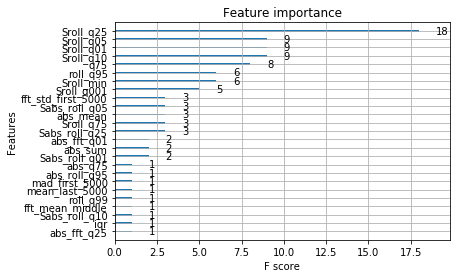

In [0]:
from xgboost import plot_importance
plot_importance(model)

# Deep learning models

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import time
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats

In [4]:
rows = 150000
segments = 4095

In [0]:
# memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 11.6 GB  | Proc size: 12.4 GB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [6]:
# Create a training file with simple derived features

print("Number of segments : ", segments)
# X_train = pd.read_csv('train.csv', nrows=segments*rows,usecols =['acoustic_data'], dtype={'acoustic_data': np.int16})#.values.reshape(-1,4095,num_features) #Read values and reshape

# Y_train = pd.read_csv('train.csv', nrows=segments*rows,usecols =['time_to_failure'], dtype={'time_to_failure': np.float64}).values.reshape(-1,segments,1) #Read values and reshape
# Y_train = np.float32(Y_train[:,-1,-1]) #We only need the last value at end of sequence


#Scale input data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_train_scaled = np.float32(X_train_scaled.reshape(-1,segments,1))
print(X_train_scaled.shape, Y_train.shape)

Number of segments :  4095
(150000, 4095, 1) (150000,)


In [4]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pickle

# pickle_out = open("X_train.pickle","wb")
# pickle.dump(X_train,pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/LANL EarthQuake Data/X_test_scaled.pickle","wb")
# pickle.dump(X_test_scaled,pickle_out)
# pickle_out.close()

# pickle_out = open("scaler_model.pickle","wb")
# pickle.dump(scaler,pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/LANL EarthQuake Data/Y_train.pickle","wb")
# pickle.dump(Y_train,pickle_out)
# pickle_out.close()


In [2]:
import pickle

# pickle_in = open("/content/drive/My Drive/LANL EarthQuake Data/X_train_scaled.pickle","rb")
# X_train_scaled = pickle.load(pickle_in)
# pickle_in.close()

pickle_in = open("X_train_scaled.pickle","rb")
X_train_scaled = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("Y_train.pickle","rb")
Y_train = pickle.load(pickle_in)
pickle_in.close()
# pickle_in = open("X_test_lst.pickle","rb")
# X_test_lst = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("/content/drive/My Drive/LANL EarthQuake Data/scaler_model.pickle","rb")
# scaler = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("/content/drive/My Drive/LANL EarthQuake Data/Y_train.pickle","rb")
# Y_train = pickle.load(pickle_in)
# pickle_in.close()

In [6]:
X_train_scaled[:2]

array([[[ 0.7027188 ],
        [ 0.1389082 ],
        [ 0.32684505],
        ...,
        [ 0.32684505],
        [ 0.1389082 ],
        [-0.14299707]],

       [[-1.6464919 ],
        [-1.8344288 ],
        [-1.0826813 ],
        ...,
        [ 0.89065564],
        [ 1.1725609 ],
        [ 1.3604977 ]]], dtype=float32)

In [0]:
submission = pd.read_csv('/content/drive/My Drive/LANL EarthQuake Data/sample_submission.csv', index_col='seg_id')


In [0]:
del X_test_lst

In [0]:
X_test_lst = []
for i, seg_id in enumerate(tqdm_notebook(submission.index)):
    seg = pd.read_csv('/content/drive/My Drive/LANL EarthQuake Data/Test/'+ seg_id + '.csv')
    index = seg_id
    X_test = pd.Series(seg['acoustic_data'].values)
    X_test_lst.append(X_test)

In [0]:
X_test_lst = np.asarray(X_test_lst)
print(type(X_test_lst))

<class 'numpy.ndarray'>


In [0]:
X_test_scaled = scaler.transform(X_test_lst)

In [0]:
X_test_scaled = X_test_scaled.reshape(-1,2624,1)
print(X_test_scaled.shape)

(150000, 2624, 1)


In [0]:
import pickle

pickle_out = open("X_test_lst.pickle","wb")
pickle.dump(X_test_lst,pickle_out)
pickle_out.close()

# pickle_in = open("X_test_lst.pickle","rb")
# X_test_lst = pickle.load(pickle_in)
# pickle_in.close()

In [ ]:
from keras.models import Sequential
import keras
from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization

In [5]:
   
earthquake_LSTM_model = Sequential()
earthquake_LSTM_model.add(LSTM(20, input_shape=(segments, 1), return_sequences=False))
# earthquake_LSTM_model.add(LSTM(20, return_sequences=False))

# earthquake_LSTM_model.add(Dense(100, activation='relu'))
earthquake_LSTM_model.add(Dense(1, activation='linear'))

earthquake_LSTM_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
print(earthquake_LSTM_model.summary())

# rmsprop = keras.optimizers.RMSprop(lr=10**-4)
# sgd = keras.optimizers.SGD(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = earthquake_LSTM_model.fit(X_train_scaled, Y_train,
          batch_size=100,
          nb_epoch=10,
          verbose=2)
# scores = model.evaluate(X_test, Y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 9156s - loss: 14.1324 - mean_squared_error: 14.1324
Epoch 2/10


In [ ]:
import pickle

pickle_out = open("earthquake_LSTM_model.pickle","wb")
pickle.dump(earthquake_LSTM_model,pickle_out)
pickle_out.close()

pickle_out = open("history.pickle","wb")
pickle.dump(history,pickle_out)
pickle_out.close()

# Comparision

In [0]:
from prettytable import PrettyTable
    
Table = PrettyTable()

Table.field_names  = ["Model","parameter","MAE"]

Table.add_row(["Linear Regression",100, 2.81566])
Table.add_row(["Random Forest",[5, 1000],1.86640])
Table.add_row(["SVR",0.1,2.02693])
Table.add_row(["XGBoost",[1, 100],1.98368])


print(Table)

+-------------------+-----------+---------+
|       Model       | parameter |   MAE   |
+-------------------+-----------+---------+
| Linear Regression |    100    | 2.81566 |
|   Random Forest   | [5, 1000] |  1.8664 |
|        SVR        |    0.1    | 2.02693 |
|      XGBoost      |  [1, 100] | 1.98368 |
+-------------------+-----------+---------+


From the table it is clear that Random Forest gives less MAE on train data

# Predicting Time to failure using Best Model

In [0]:
y_pred_RF = RF_reg.predict(X_test)

In [0]:
y_pred_RF[0:5]

array([2.45670841, 2.35490238, 2.42256184, 2.46969583, 2.4505092 ])

## Saving the result into sample submission file, each result corrospond to each seg_id

In [0]:
submission = pd.read_csv("sample_submission.csv")
submission['time_to_failure'] = y_pred_RF
submission.to_csv("result.csv",index = False)

In [0]:
submission = pd.read_csv("result.csv")
submission.head()

,seg_id,time_to_failure
0,seg_00030f,2.456708406452895
1,seg_0012b5,2.354902382732236
2,seg_00184e,2.422561836157360
3,seg_003339,2.469695830640888
4,seg_0042cc,2.450509200384697


# Refrences :

https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463

https://www.youtube.com/watch?v=TffGdSsWKlA

https://medium.com/@snehasathishdeva/lanl-earthquake-prediction-predict-upcoming-laboratory-earthquakes-c2e5968701

https://github.com/llSourcell/Kaggle_Earthquake_challenge/blob/master/Earthquake_Challenge.ipynb

https://medium.com/making-sense-of-data/time-series-next-value-prediction-using-regression-over-a-rolling-window-228f0acae363
